# Dopamine modulation on BG

**Observation**: increase in beta-range spectral power is observed without dopamine modulation of CTX input to MSN-D1 and MSN-D2.

**Method**: I used the network model from Ortone and the model of dopamine modulation from Lindahl(2016). In particular, if an attribute $x$ of the network is subject to dopaminergic modulation, the effect of dopamine levels are modeled by

$$ x(\alpha) = x_0(1+\chi_x (\alpha -\alpha_0))$$
where $\alpha$ represents the dopamine level and $x_0$ is the value of the parameter at standard dopamine ($\alpha_0 = 0.8$, Lindahl). In the following, $\chi_x$ will be called generalized susceptibility.

The **main differences** between Ortone and Lindahl networks are:

- size of populations
- synaptic model
- cortical inputs: no AMPA/NMDA differentiation, different rates and weights
- STN subthreshold/suprathreshold adaptation parameter ada_a (Ortone: 0, Lindahl 0.3)
- Rest potential of FSN (Ortone: -80, Lindahl: -64.4). This attribute is negatively susceptible to dopamine, so FSN in Lindahl's network is already dopamine-depleted w.r.t. Ortone's network;
- SNr synaptic fan-in (from MSN-D1 Ortone: 59, Lindahl: 500; from GPeTI Ortone:25, Lindahl: 32 ). This is not particularly relevant for now since SNr is an output;

In [1]:
import yaml
from rich import print

NEURONS_FILE = "ortone_neurons.yaml"
NETWORK_FILE = "ortone_network.yaml"
DOPAMINE_FILE = "lindahl_dopamine_susceptibility_noctx_disentangled.yaml"

print("List of dopamine-dependent attributes:")
with open(DOPAMINE_FILE, "r") as dopfile:
    susceptiblities = yaml.safe_load(dopfile)['parametric']['dopamine']

for item in susceptiblities:
    if 'population' in item.keys():
        print(f"Attribute {item['attribute']:15} of population {item['population']:15}: chi = {item['susceptibility']}")
    elif 'projection' in item.keys():
        print(f"Attribute {item['attribute']:10} of projection {item['projection']:15}: chi = {item['susceptibility']}")

List of dopamine-dependent attributes:

Attribute E_l             of population FSN            : chi = -0.078

Attribute E_l             of population GPeTI          : chi = -0.181

Attribute E_l             of population GPeTA          : chi = -0.181

Attribute V_peak          of population D1             : chi = 0.0296

Attribute ada_b           of population D1             : chi = -0.45

Attribute E_l             of population SNR            : chi = -0.0896

Attribute weight     of projection FSN->FSN       : chi = -1.27

Attribute weight     of projection GPeTA->FSN     : chi = -0.53

Attribute weight     of projection GPeTI->FSN     : chi = -0.53

Attribute weight     of projection GPeTA->GPeTA   : chi = -0.83

Attribute weight     of projection GPeTA->GPeTI   : chi = -0.83

Attribute weight     of projection GPeTI->GPeTI   : chi = -0.83

Attribute weight     of projection GPeTI->GPeTA   : chi = -0.83

Attribute weight     of projection D2->GPeTI      : chi = -0.83

Attribute weight     of projection STN->GPeTA     : chi = -0.45

Attribute weight     of projection STN->GPeTI     : chi = -0.45

Attribute connectivity of projection FSN->D2        : chi = -0.9

Attribute connectivity of projection D1->D1         : chi = 0.88

Attribute connectivity of projection D1->D2         : chi = 0.88

Attribute connectivity of projection D2->D1         : chi = 0.88

Attribute connectivity of projection D2->D2         : chi = 0.88

Attribute weight     of projection D1->D1         : chi = 0.88

Attribute weight     of projection D1->D2         : chi = 0.88

Attribute weight     of projection D2->D1         : chi = 0.88

Attribute weight     of projection D2->D2         : chi = 0.88

Attribute weight     of projection GPeTA->D1      : chi = -1.15

Attribute weight     of projection D1->SNR        : chi = 0.56

Attribute weight     of projection GPeTI->STN     : chi = -0.24

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
%matplotlib inline
# %matplotlib ipympl

## Parameters of the simulation

In [3]:
Tlong = 8000  # ms
dt = 0.1      # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency
burn_in_millis = 600      # the first part of the record to discard (ms)

# Params for trials
n_trials = 10
Tshort = 1500 # ms

# Rescaling of populations: Lindahl network is unbearable on my machine
# so populations are rescaled to match sizes from Ortone
populations_scaling = dict()
if NETWORK_FILE == "lindahl_network.yaml":
    populations_scaling = dict( MSN_scale= -0.84,
                                FSN_scale= -0.74,
                                GPe_scale= -0.22,
                                STN_scale= 0.05
                                )

reasonable_firing = dict(FSN=15, D1=1.5, D2=1.5, GPeTI=50, GPeTA=10, STN=16)
# FSN [10-20] Hz 
# D1, D2 [0.5–2.5] Hz
# GPe-TI [40–60] Hz
# GPe-TA [5–15] Hz 
# and STN [12–20] Hz


## Utils & plots

In [4]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy import stats

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data('spikes')
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    beta_mask = (f>=12)&(f<30)
    low_gamma_mask = (f>=30)&(f<50)
    high_gamma_mask = (f>=50)&(f<90)
    
    norm_beta = simpson(PSD[beta_mask], x=f[beta_mask])
    fmean = simpson(f[beta_mask]*PSD[beta_mask]/norm_beta, x=f[beta_mask])

    spectral_norm = simpson(PSD, x=f)
    result = dict(
        fmax = f[np.argmax(PSD)],
        fmean=fmean,
        
        norm_beta_power=simpson(PSD[beta_mask], x=f[beta_mask])/spectral_norm,
        norm_low_gamma_power=simpson(PSD[low_gamma_mask], x=f[low_gamma_mask])/spectral_norm,
        norm_high_gamma_power=simpson(PSD[high_gamma_mask], x=f[high_gamma_mask])/spectral_norm,

        beta_power = simpson(PSD[beta_mask], x=f[beta_mask]),
        low_gamma_power = simpson(PSD[low_gamma_mask], x=f[low_gamma_mask]),
        high_gamma_power = simpson(PSD[high_gamma_mask], x=f[high_gamma_mask]),

        entropy=stats.entropy(PSD/spectral_norm),
    )
    
    return result

def firing_rate(sn, population):
    binned_spikes = bin_spikes(sn.populations[population].get_data('spikes'))
    instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
    return np.mean(instantaneous_fr)

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def get_PSD(sn, pop, frequency_resolution=0.5, smooth=False):
    spikes = sn.populations[pop].get_data('spikes')
    binned_spikes = bin_spikes(spikes)
    binned_spikes = binned_spikes[burn_in_millis:]
    T = len(binned_spikes)
    # print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")

    N = sampling_frequency/frequency_resolution
    
    if N > T/2:
        print(N)
        print(f"Not enough points to achieve resolution of {frequency_resolution}")
        N = T/2

    nfft = 10_000 if smooth else None
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg=N, 
                   noverlap=N/2,
                   nfft=nfft,
                   scaling='density', 
                   window='hamming')
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    norm = simpson(PSD, x=f)
    return f, PSD

In [5]:
def plot_spectrum(sn, scale="log", pops=None):
    if pops is None:
        pops = sn.populations
    fig, axes = plt.subplots(len(pops), 1, sharex=True)
    for ax, pop in zip(axes, pops):
        f, PSD = get_PSD(sn, pop)
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale(scale)
    # print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(10, 30)
    fig.set_figheight(8.5)
    return fig

def plot_signals(sn, pops=None):
    if pops is None:
        pops = sn.populations.keys()
    colors = sns.color_palette("rainbow", 10)

    fig, ax = plt.subplot_mosaic([[pop] for pop in pops],sharex=True, figsize=(8,2*len(pops)))

    for pop in pops:    
        binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax[pop].plot(tt, instantaneous_fr, color="#c3c3c3", label="raw")
            
        ax[pop].plot(tt,np.mean(instantaneous_fr) + bandpass(instantaneous_fr, [12, 30], sampling_frequency), label=r"$\beta$", color=colors[9])
        ax[pop].plot(tt, np.mean(instantaneous_fr)  + bandpass(instantaneous_fr, [30, 90], sampling_frequency), label=r"$\gamma$", color=colors[2])
        
        ax[pop].set_xlim(6, 7)
        ax[pop].set_ylabel(f"{pop} [Hz]")
        ax[pop].legend()
    
    leg = ax[pops[0]].get_legend()
    for a in ax.values():
        a.legend().remove()
    
    fig.legend(handles=leg.legend_handles, loc='upper right')
    
    ax[pops[-1]].set_xlabel("time [s]")
    return fig


## Building the network

In [6]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

In [7]:
from quilt.builder import NeuronCatalogue, ParametricSpikingNetwork

sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        NEURONS_FILE,
                                        [DOPAMINE_FILE], 
                                         # DISPERSION_FILE, "dbs.yaml"]
                                       )
sn.monitorize_spikes()
# sn.monitorize_states("GPeTA")

## Control case (healthy subject)

In [130]:
sn.set_parameters(dopamine=1.0)
sn.run(dt=dt, time=Tlong)

(7.0, 8.0)

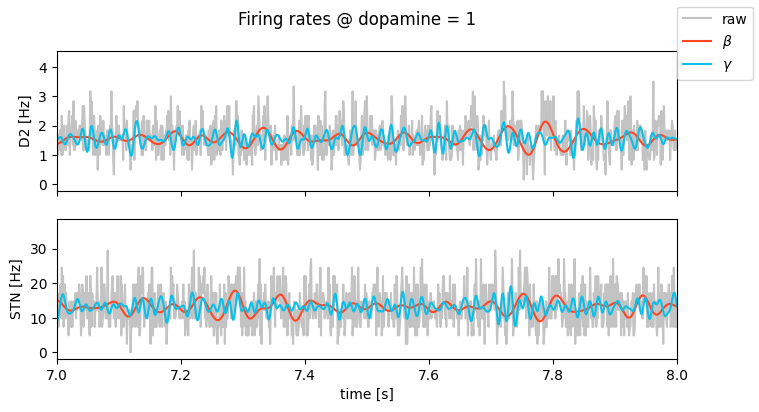

In [131]:
plot_signals(sn, pops=['D2', 'STN']);
plt.gcf().suptitle('Firing rates @ dopamine = 1');
plt.gca().set_xlim(7, 8)

(0.0, 500.0)

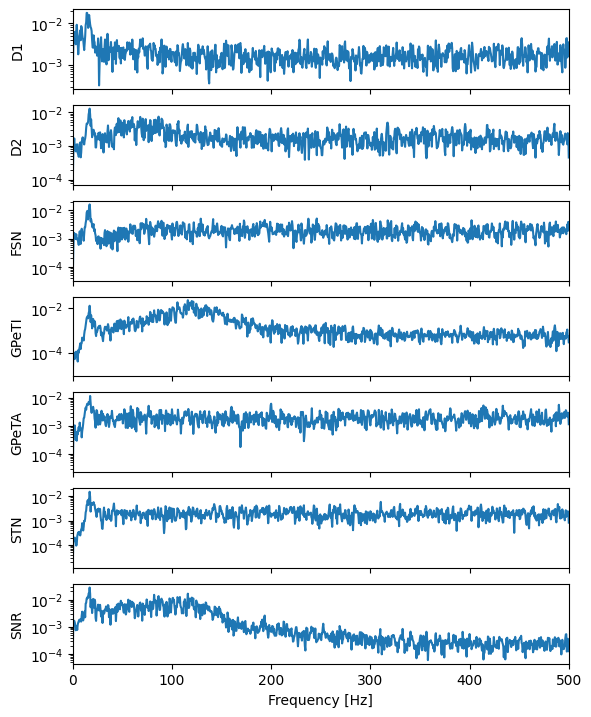

In [136]:
plot_spectrum(sn)
plt.gca().set_xlim(0, 500)

## Lesioned case (PD)

In [22]:
sn.set_parameters(dopamine=0.4)
sn.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 144 s	(1.80481 ms/step)
	Gathering time avg: 0.459075 us/step
	Inject time avg: 208.954 us/step
Population evolution stats:
	0:
		evolution:	490.802 us/step	---	81 ns/step/neuron
		spike emission:	69.0827 us/step	---	11 ns/step/neuron
	1:
		evolution:	451.023 us/step	---	75 ns/step/neuron
		spike emission:	64.9388 us/step	---	10 ns/step/neuron
	2:
		evolution:	87.7944 us/step	---	209 ns/step/neuron
		spike emission:	15.786 us/step	---	37 ns/step/neuron
	3:
		evolution:	115.986 us/step	---	148 ns/step/neuron
		spike emission:	20.9448 us/step	---	26 ns/step/neuron
	4:
		evolution:	64.8404 us/step	---	249 ns/step/neuron
		spike emission:	5.17226 us/step	---	19 ns/step/neuron
	5:
		evolution:	74.1695 us/step	---	181 ns/step/neuron
		spike emission:	6.3155 us/step	---	15 ns/step/neuron
	6:
		evolution:	114.105 u

(7.0, 8.0)

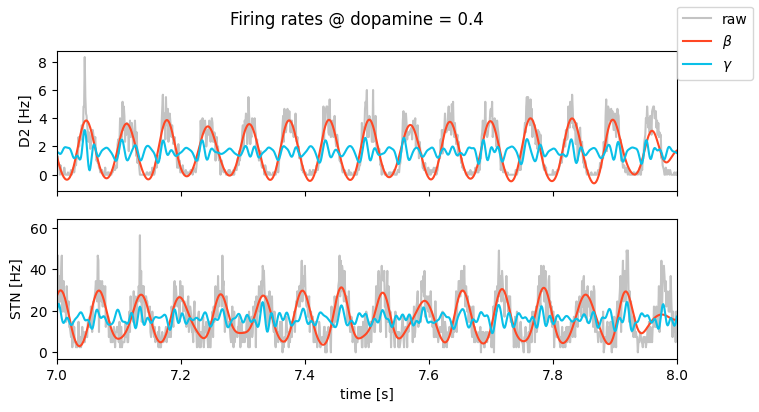

In [128]:
plot_signals(sn, pops=['D2', 'STN']);
plt.gcf().suptitle('Firing rates @ dopamine = 0.4');
plt.gca().set_xlim(7, 8)

## Comparison

In [23]:
dopamines = [0.6, 0.7, 0.8, 0.9, 1]

nets = []
for dopamine in dopamines:
    nets.append(ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                            NEURONS_FILE,
                                            [DOPAMINE_FILE]))
    nets[-1].set_parameters(dopamine=dopamine)
    nets[-1].monitorize_spikes()

In [24]:
for net in nets:
    net.run(dt=dt, time=Tlong)

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 141 s	(1.76616 ms/step)
	Gathering time avg: 0.034625 us/step
	Inject time avg: 187.085 us/step
Population evolution stats:
	0:
		evolution:	489.751 us/step	---	81 ns/step/neuron
		spike emission:	77.9085 us/step	---	12 ns/step/neuron
	1:
		evolution:	437.217 us/step	---	72 ns/step/neuron
		spike emission:	71.6764 us/step	---	11 ns/step/neuron
	2:
		evolution:	86.4559 us/step	---	205 ns/step/neuron
		spike emission:	14.4197 us/step	---	34 ns/step/neuron
	3:
		evolution:	111.494 us/step	---	142 ns/step/neuron
		spike emission:	21.2745 us/step	---	27 ns/step/neuron
	4:
		evolution:	62.6514 us/step	---	240 ns/step/neuron
		spike emission:	4.6347 us/step	---	17 ns/step/neuron
	5:
		evolution:	72.8672 us/step	---	178 ns/step/neuron
		spike emission:	6.05361 us/step	---	14 ns/step/neuron
	6:
		evolution:	108.714 

IOStream.flush timed out


Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 130 s	(1.63701 ms/step)
	Gathering time avg: 0.0452 us/step
	Inject time avg: 175.529 us/step
Population evolution stats:
	0:
		evolution:	429.647 us/step	---	71 ns/step/neuron
		spike emission:	68.7478 us/step	---	11 ns/step/neuron
	1:
		evolution:	410.264 us/step	---	68 ns/step/neuron
		spike emission:	65.2782 us/step	---	10 ns/step/neuron
	2:
		evolution:	81.3065 us/step	---	193 ns/step/neuron
		spike emission:	13.3239 us/step	---	31 ns/step/neuron
	3:
		evolution:	108.873 us/step	---	139 ns/step/neuron
		spike emission:	21.3583 us/step	---	27 ns/step/neuron
	4:
		evolution:	61.4502 us/step	---	236 ns/step/neuron
		spike emission:	4.27814 us/step	---	16 ns/step/neuron
	5:
		evolution:	71.5834 us/step	---	175 ns/step/neuron
		spike emission:	5.48179 us/step	---	13 ns/step/neuron
	6:
		evolution:	105.918 u

IOStream.flush timed out


Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 140 s	(1.75831 ms/step)
	Gathering time avg: 0.129637 us/step
	Inject time avg: 186.533 us/step
Population evolution stats:
	0:
		evolution:	464.182 us/step	---	77 ns/step/neuron
		spike emission:	62.7732 us/step	---	10 ns/step/neuron
	1:
		evolution:	443.89 us/step	---	73 ns/step/neuron
		spike emission:	75.527 us/step	---	12 ns/step/neuron
	2:
		evolution:	88.3833 us/step	---	210 ns/step/neuron
		spike emission:	14.0869 us/step	---	33 ns/step/neuron
	3:
		evolution:	117.239 us/step	---	150 ns/step/neuron
		spike emission:	24.2248 us/step	---	31 ns/step/neuron
	4:
		evolution:	65.1241 us/step	---	250 ns/step/neuron
		spike emission:	5.76574 us/step	---	22 ns/step/neuron
	5:
		evolution:	75.848 us/step	---	185 ns/step/neuron
		spike emission:	5.76634 us/step	---	14 ns/step/neuron
	6:
		evolution:	114.669 us

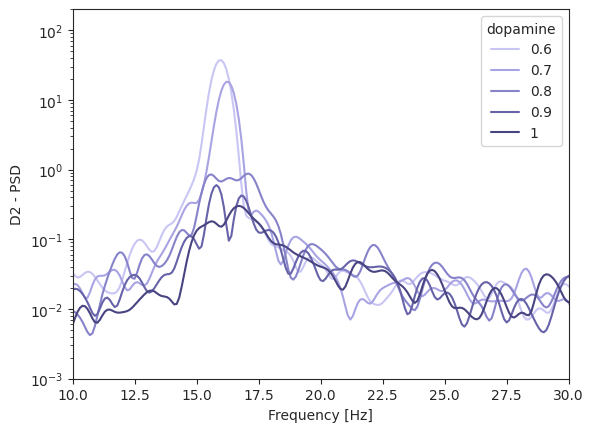

In [25]:
fig, ax = plt.subplots()
D2_colors = sns.cubehelix_palette(start=0, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)
STN_colors = sns.cubehelix_palette(start=1.3, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)

sns.set_style("ticks")

for i in range(len(nets)):
    ax.plot(*get_PSD(nets[i], "D2", frequency_resolution=0.5, smooth=True), label=dopamines[i], color=D2_colors[i])

ax.set_yscale('log')
ax.set_xlim(10, 30)
plt.legend(title="dopamine")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("D2 - PSD")
ax.set_ylim(1e-3, 2e2)
plt.savefig("images/D2-PSD.pdf")

NameError: name 'nets' is not defined

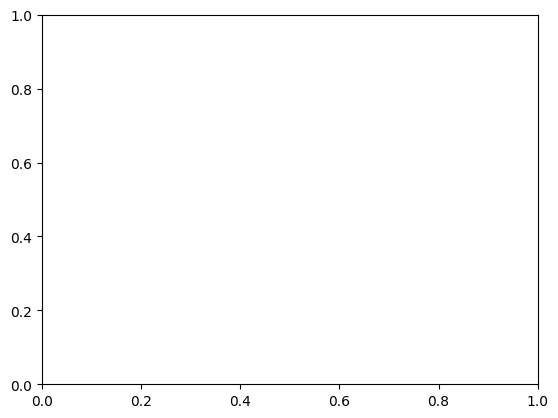

In [129]:
fig, ax = plt.subplots()
STN_colors = sns.cubehelix_palette(start=1.3, rot=0, dark=0.3, light=0.8, reverse=False, n_colors=len(nets), hue=1)

sns.set_style("ticks")

for i in range(len(nets)):
    ax.plot(*get_PSD(nets[i], "STN", frequency_resolution=0.5, smooth=True), label=dopamines[i], color=STN_colors[i])
    # ax.plot(*get_PSD(nets[i], "STN"), label="STN", color=STN_colors[i])
ax.set_yscale('log')
ax.set_xlim(10, 2000)
plt.legend(title="dopamine")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("STN - PSD")
ax.set_ylim(1e-3, 2e2)
plt.savefig("images/STN-PSD.pdf")

## Trend

In [27]:
from rich.progress import track

set_verbosity(0)
beta_powers = dict()
fmaxs = dict()
beta_powers_normalized = dict()
entropies = dict()

for pop in sn.spike_monitored_pops:
    fmaxs[pop] = []
    beta_powers[pop] = []
    beta_powers_normalized[pop] = []
    entropies[pop] = []
    
dopamine_levels = np.linspace(0.2, 0.9, 20)

for dopamine in track(dopamine_levels, total=len(dopamine_levels)):
    sn.set_parameters(dopamine=dopamine)
    sn.run(dt=dt, time=1600)
    for pop in sn.populations.keys():
        fmax, normbeta, beta, entropy = beta_power(sn, pop)
        fmaxs[pop] += [fmax]
        beta_powers_normalized[pop] += [normbeta]
        beta_powers[pop] += [beta]
        entropies[pop] += [entropy]

Output()

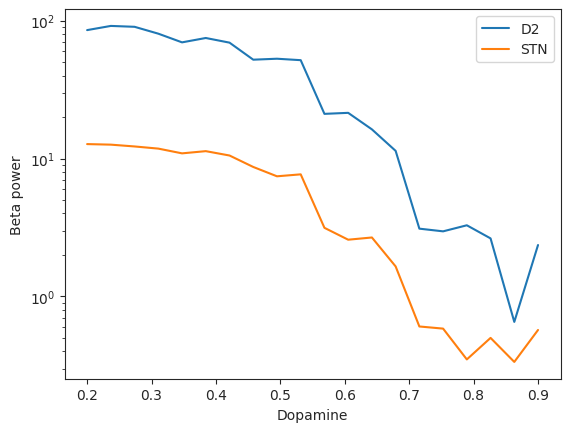

In [35]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, beta_powers[pop], label=pop)
plt.ylabel("Beta power")
plt.xlabel("Dopamine")
plt.yscale('log')
plt.legend()

(13.0, 17.0)

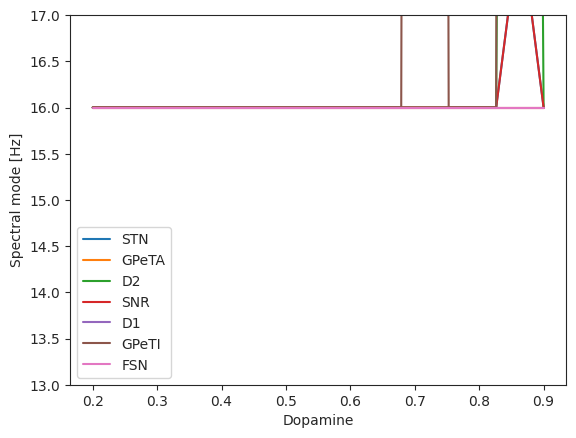

In [34]:
for pop in fmaxs:
    plt.plot(dopamine_levels, fmaxs[pop], label=pop)
# plt.yscale('log')
plt.ylabel("Spectral mode [Hz]")
plt.xlabel("Dopamine")
plt.legend()
plt.ylim(13, 17)

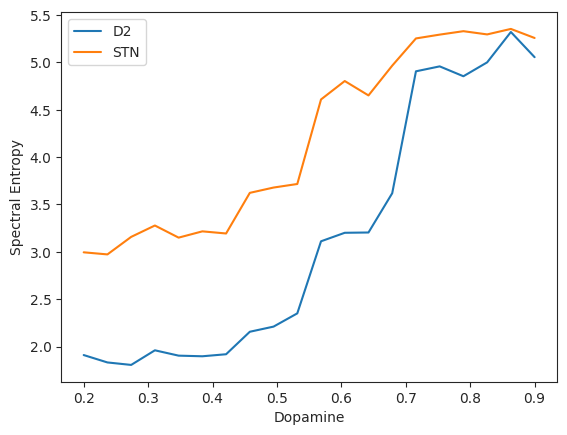

In [30]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, entropies[pop], label=pop)
# plt.yscale('log')
plt.xlabel("Dopamine")
plt.ylabel("Spectral Entropy")
plt.legend()

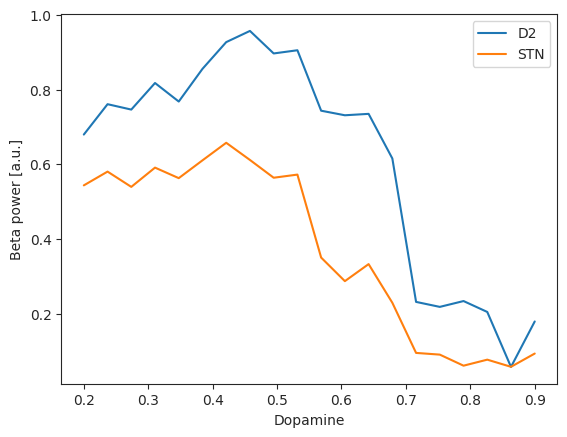

In [31]:
for pop in ["D2", "STN"]:
    plt.plot(dopamine_levels, beta_powers_normalized[pop], label=pop)
# plt.yscale('log')
plt.ylabel("Beta power [a.u.]")
plt.xlabel("Dopamine")
plt.legend()

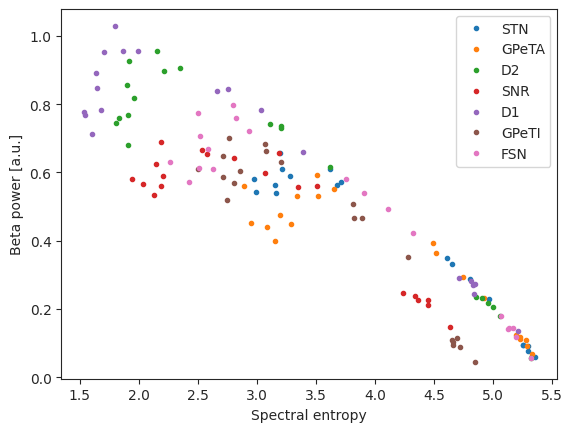

In [32]:
for pop in beta_powers_normalized:
    plt.plot(entropies[pop], beta_powers_normalized[pop], label=pop, ls="", marker=".")
plt.xlabel("Spectral entropy")
plt.ylabel("Beta power [a.u.]")
plt.legend()

## plot 2D

In [ ]:
from scipy.integrate import simpson
def bin_spectrum(f, PSD, n_bins=20, fmax=90):
    norm = simpson(PSD[f<fmax], x=f[f<fmax])
    
    binned_spectrum = np.zeros(n_bins)
    frequency_bin_width = fmax/n_bins
    for i in range(n_bins):
        f_mask = (f > i*frequency_bin_width)&(f < (i+1)*frequency_bin_width)
        # binned_spectrum[i] = simpson(PSD[f_mask], x=f[f_mask])/norm
    return binned_spectrum

In [ ]:
from rich.progress import track

set_verbosity(0)

spectral_resolution = 2.5
N_dopamine_levels = int(90/spectral_resolution)
N_spectral_bins = int(90/spectral_resolution)
dopamine_levels = np.linspace(0.2, 1.0, N_dopamine_levels)

spectra = dict()
for pop in sn.features_dict['populations']:
    spectra[pop] = np.zeros((N_dopamine_levels, N_spectral_bins))

for i in track(range(N_dopamine_levels), total=len(dopamine_levels)):
    sn.set_parameters(dopamine=dopamine_levels[i], 
                      delay_dispersion=-1, 
                      **populations_scaling)
    sn.run(dt=dt, time=3 * sampling_frequency/spectral_resolution + burn_in_millis ) # Uses 3 complete windows at minimal resolution
    for pop in sn.populations.keys():
        f, PSD = get_PSD(sn, pop, frequency_resolution=spectral_resolution)
        plt.show()
        spectra[pop][i] = PSD[f<90]
    

In [ ]:
X, Y = np.meshgrid(dopamine_levels, np.linspace(0, 90, int(90/spectral_resolution)))
# pop = "GPeTA"
for pop in sn.populations:
    plt.pcolormesh(X, Y, np.log10(spectra[pop].T + 1e-10))
    plt.xlabel("Dopamine")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label = "Log PSD")
    plt.title(f"{pop} - PSD")
    plt.savefig(f"images/logPSD_{pop}.pdf")
    plt.show()

## Statistical features of the signal

In [138]:
def plot_spikecount_distrib(sn):
    for pop in sn.populations:
        fig, (ax1, ax2) = plt.subplots(2,1)
        ax1.set_title(pop)
        spikes = sn.populations[pop].get_data('spikes')
        spikes = spikes[5000:]
        ax2.plot(spikes)
        # ax2.plot(bin_spikes(spikes))
        from scipy.special import factorial
        nn = np.arange(np.min(spikes), np.max(spikes))
        histogram, bins = np.histogram(spikes, bins=nn, density=True)
        ax1.step(bins[:-1], histogram, where='mid', marker=".", label="Spike count")
        l = np.mean(spikes)
        print(l)
        ax1.step(nn, l**nn*np.exp(-l)/factorial(nn.astype(int)), marker=".", where='mid', label=r"Poisson ($\lambda$ = $\langle N \rangle$)")
        ax1.legend()
        plt.show()

In [140]:
sn.set_parameters(dopamine=1.0)
sn.run(dt=dt, time=Tshort)

Running network consisting of 14622 neurons for 15000 timesteps
--------------------------------------------------
**************************************************
Simulation took 27 s	(1.84288 ms/step)
	Gathering time avg: 0.0571962 us/step
	Inject time avg: 188.8 us/step
Population evolution stats:
	0:
		evolution:	507.788 us/step	---	84 ns/step/neuron
		spike emission:	61.4879 us/step	---	10 ns/step/neuron
	1:
		evolution:	479.807 us/step	---	79 ns/step/neuron
		spike emission:	84.4828 us/step	---	14 ns/step/neuron
	2:
		evolution:	91.9681 us/step	---	218 ns/step/neuron
		spike emission:	14.0446 us/step	---	33 ns/step/neuron
	3:
		evolution:	116.209 us/step	---	148 ns/step/neuron
		spike emission:	24.1784 us/step	---	30 ns/step/neuron
	4:
		evolution:	63.1586 us/step	---	242 ns/step/neuron
		spike emission:	6.05813 us/step	---	23 ns/step/neuron
	5:
		evolution:	73.6533 us/step	---	180 ns/step/neuron
		spike emission:	5.17332 us/step	---	12 ns/step/neuron
	6:
		evolution:	112.299 u

0.42425757424257576

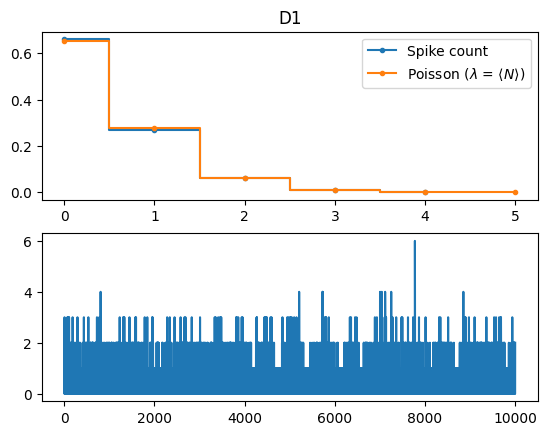

0.9667033296670333

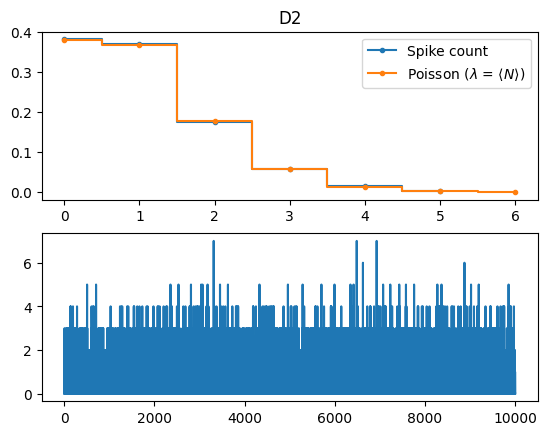

0.7015298470152985

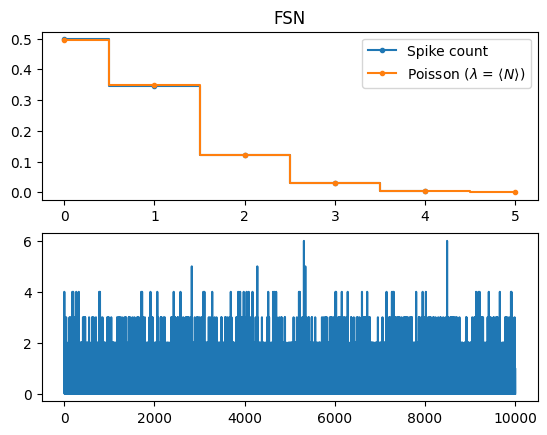

5.096090390960904

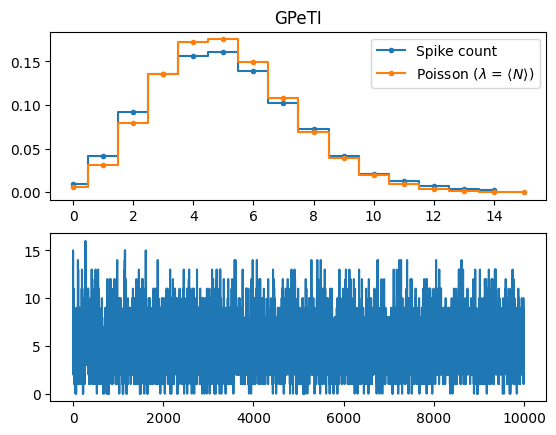

0.250974902509749

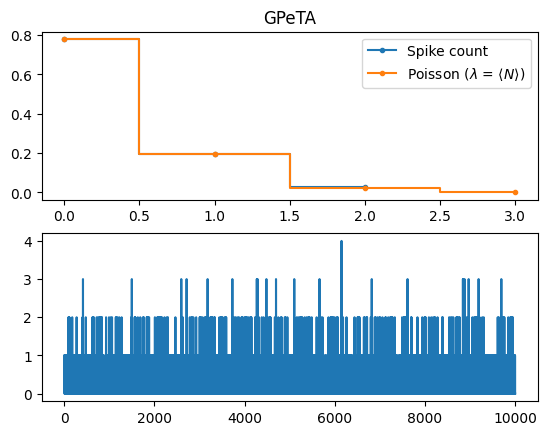

0.5445455454454554

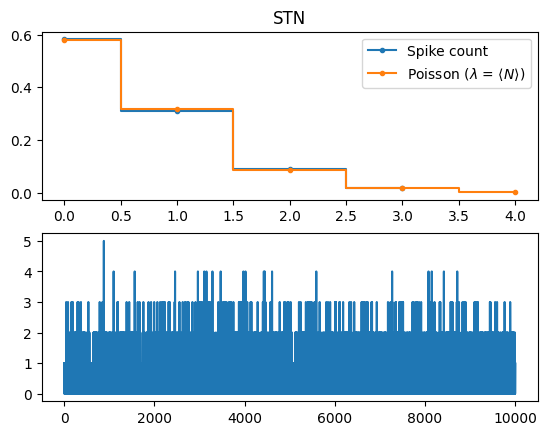

1.0186981301869813

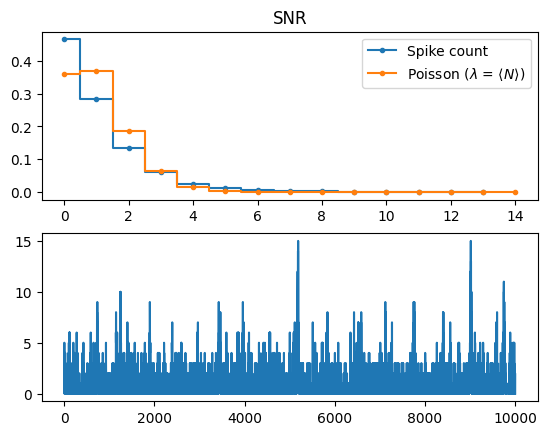

In [141]:
plot_spikecount_distrib(sn)

In [142]:
sn.set_parameters(dopamine=0.4)
sn.run(dt=dt, time=Tshort)

Running network consisting of 14622 neurons for 15000 timesteps
--------------------------------------------------
**************************************************
Simulation took 24 s	(1.66349 ms/step)
	Gathering time avg: 0.0191321 us/step
	Inject time avg: 170.769 us/step
Population evolution stats:
	0:
		evolution:	453.969 us/step	---	75 ns/step/neuron
		spike emission:	64.4178 us/step	---	10 ns/step/neuron
	1:
		evolution:	425.404 us/step	---	70 ns/step/neuron
		spike emission:	59.2918 us/step	---	9 ns/step/neuron
	2:
		evolution:	83.1975 us/step	---	198 ns/step/neuron
		spike emission:	12.8283 us/step	---	30 ns/step/neuron
	3:
		evolution:	110.351 us/step	---	141 ns/step/neuron
		spike emission:	19.2656 us/step	---	24 ns/step/neuron
	4:
		evolution:	62.6107 us/step	---	240 ns/step/neuron
		spike emission:	3.955 us/step	---	15 ns/step/neuron
	5:
		evolution:	70.6614 us/step	---	173 ns/step/neuron
		spike emission:	5.75975 us/step	---	14 ns/step/neuron
	6:
		evolution:	107.405 us

1.7903209679032097

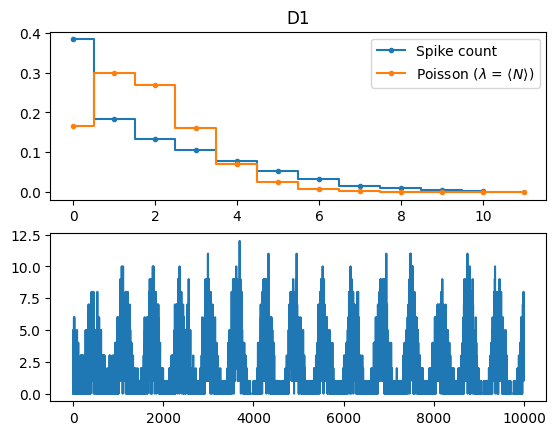

0.9617038296170383

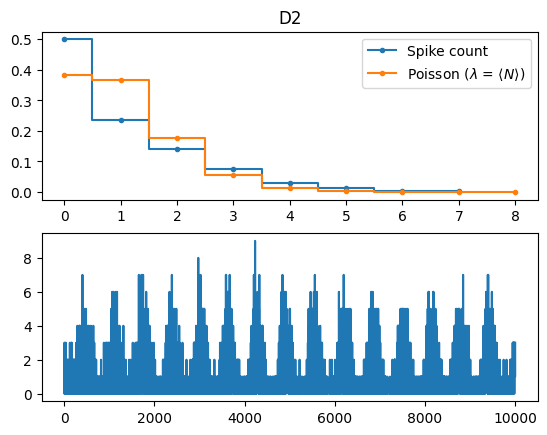

0.6118388161183882

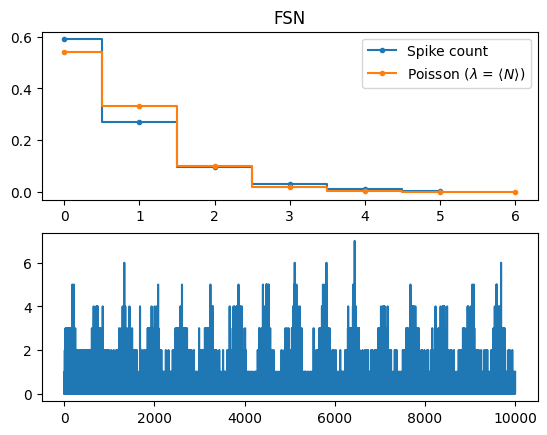

3.9148085191480853

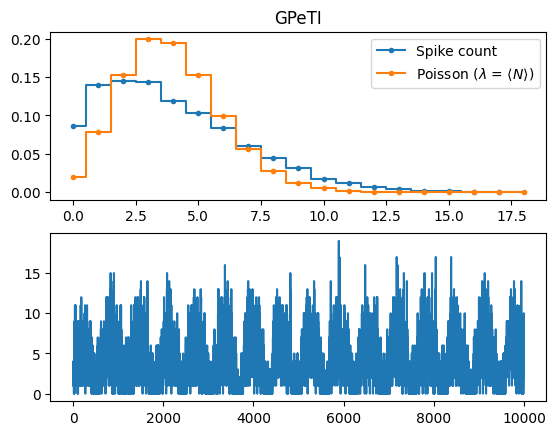

0.15528447155284472

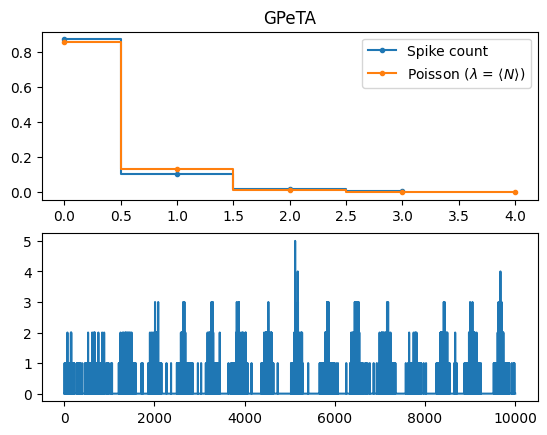

0.662933706629337

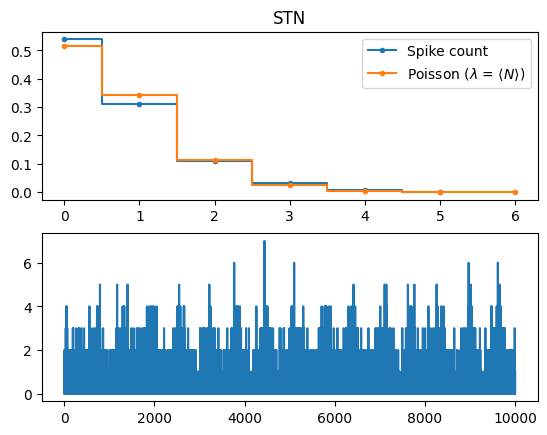

7.371762823717628

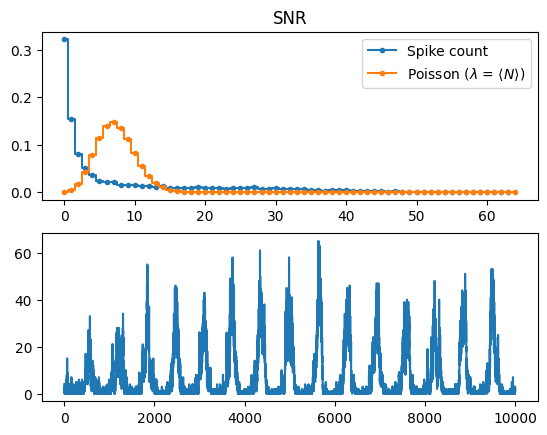

In [144]:
plot_spikecount_distrib(sn)

## Estimating rate functions

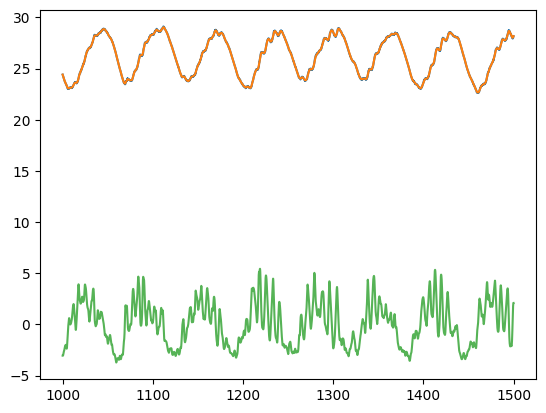

In [222]:
spikes = sn.populations['GPeTI'].get_data('spikes')
tt = np.linspace(0, Tshort, len(spikes))

mask = tt >1000

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(tt[mask].reshape(-1,1), np.cumsum(spikes)[mask])

m_fit = model.coef_[0]
b_fit = model.intercept_ 
L = np.cumsum(spikes)[mask] - m_fit*tt[mask]
plt.plot(tt[mask], 0.01*L)
for j in range(15):
    for i in range(1, len(tt[mask])-1):
        L[i] = 0.5*(L[i+1] + L[i-1])
plt.plot(tt[mask], 0.01*L)
plt.plot(tt[mask][:-1], 0.1*np.diff(L)/np.diff(tt[mask]), alpha=0.8)
# plt.ylim(0, 0.25)

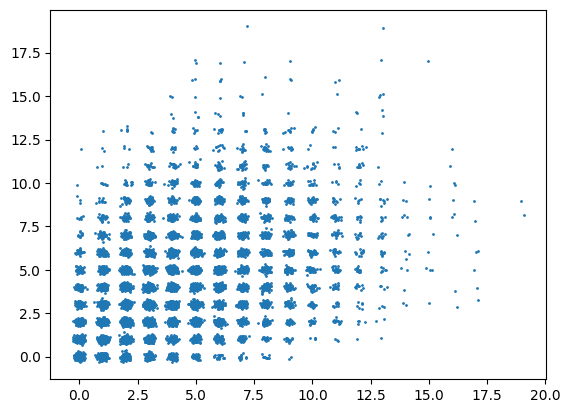

In [225]:
k = 5 
plt.scatter(spikes[:-k]+np.random.normal(0, 0.1, size=len(spikes[:-k])), spikes[k:]+np.random.normal(0, 0.1, size=len(spikes[:-k])), s=1)

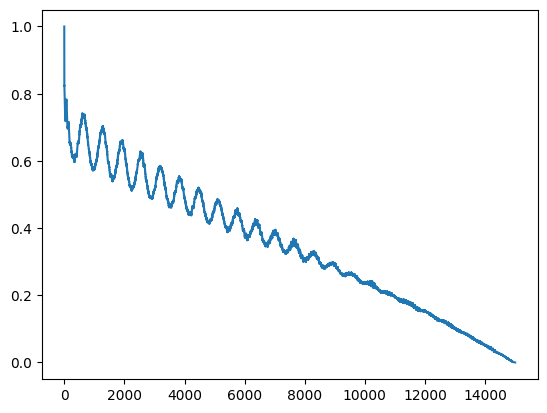

In [226]:
from scipy.signal import correlate
gg = correlate(spikes, spikes, mode='full')/np.std(spikes)**2
gg = gg[len(gg)//2:]
gg /= gg[0]
plt.plot(gg)

(0.0, 1000.0)

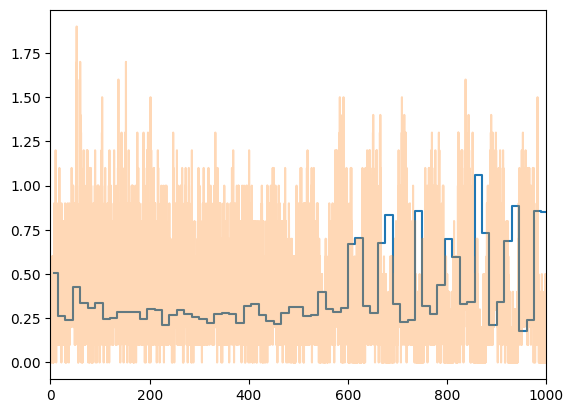

In [257]:
cvs = []
times = []
k = 100
for bunch, ttt in zip(np.split(spikes[:-(len(spikes)%k)], k),
                     np.split(tt[:-(len(spikes)%k)], k)):
    times.append(0.5*(ttt[0] + ttt[-1]))
    cvs.append(np.std(bunch)**2/np.mean(bunch)**2)
plt.step(times, cvs, where='mid')
plt.plot(tt, spikes/10, alpha=0.3)
plt.xlim(0, 1000)

## Relevance analysis

In [25]:
import yaml

with open(DOPAMINE_FILE, "r") as f:
    parameters_dict = yaml.safe_load(f)

new_parameters_dict = dict(parameters=dict(), parametric=dict())
counter = 0
for parametric in parameters_dict['parametric']['dopamine']:
    if 'population' in parametric:
        name = parametric['population'].replace(" ", "") + "_" + parametric['attribute'] 
    elif 'projection' in parametric:
        name = parametric['projection'].replace(" ", "") + "_" + parametric['attribute'] 
        
    new_parameters_dict["parameters"].update({name : {'min': 0, 'max': 1, 'shift': 0.8}})
    new_parameters_dict["parametric"][name] =[parametric]

In [26]:
from quilt.builder import ParametricSpikingNetwork
net = ParametricSpikingNetwork.from_dict(new_parameters_dict, network_file=NETWORK_FILE, neuron_file=NEURONS_FILE)
net.monitorize_spikes()

#### General sampling

In [259]:
import pandas as pd
from rich.progress import track
N = 200
eps = 1.0
alpha0 = 0.5
burn_in_millis=1000

set_verbosity(0)

results = pd.DataFrame()
for i in track(range(N)):
    dopamine_array = dict()
    
    for parameter in new_parameters_dict['parameters']:
        dopamine_array[parameter] = alpha0 + eps/2*np.random.uniform(-1, 1)
    net.set_parameters(**dopamine_array)

    net.run(dt=0.1, time=5000)

    row = dopamine_array.copy()

    for pop in net.populations.keys():
        fmax, fmean, norm_beta_pow, beta_pow, entropy = beta_power(net, pop)
        row[f"{pop}_norm_beta_power"] = norm_beta_pow
        row[f"{pop}_beta_power"] = beta_pow
        row[f"{pop}_fmax"] = fmax
        row[f"{pop}_entropy"] = entropy
        row[f"{pop}_fmean"] = fmean
    results = pd.concat([results, pd.DataFrame(row, index=[i])])

results.to_csv("multidim_dopamine_6.csv")
display(results)

Output()

FSN_E_l  GPeTI_E_l  GPeTA_E_l  D1_V_peak  D1_ada_b   SNR_E_l  \
0    0.174438   0.837865   0.784388   0.578024  0.221262  0.517723   
1    0.801217   0.487803   0.535003   0.311460  0.495639  0.139171   
2    0.750299   0.451186   0.389760   0.141211  0.742066  0.122370   
3    0.786301   0.482061   0.027567   0.298052  0.357152  0.783105   
4    0.765599   0.282996   0.678708   0.086201  0.705370  0.472861   
..        ...        ...        ...        ...       ...       ...   
195  0.105074   0.433997   0.454869   0.906828  0.259077  0.868887   
196  0.041849   0.180365   0.023100   0.470042  0.098419  0.225740   
197  0.752422   0.816265   0.421726   0.517461  0.291431  0.636735   
198  0.544801   0.712493   0.301841   0.931527  0.690221  0.881786   
199  0.388181   0.631054   0.782290   0.590631  0.025415  0.544065   

     FSN->FSN_weight  GPeTA->FSN_weight  GPeTI->FSN_weight  \
0           0.377405           0.430769           0.995154   
1           0.604451           0.490099           0.096474   
2           0.110522           0.510566           0.813406   
3           0.208727           0.062827           0.853196   
4           0.826392           0.107950           0.850240   
..               ...                ...                ...   
195         0.686225           0.911859           0.233923   
196         0.852480           0.334559           0.525052   
197         0.063688           0.650267           0.500087   
198         0.546128           0.142732           0.524609   
199         0.234797           0.542013           0.251959   

     GPeTA->GPeTA_weight  ...  GPeTA_fmax  GPeTA_entropy  STN_norm_beta_power  \
0               0.490594  ...        13.5       6.742607             0.132819   
1               0.790092  ...        15.5       3.280512             0.584592   
2               0.337303  ...        16.5       3.948684             0.432384   
3               0.018512  ...        15.0       5.232911             0.495758   
4               0.797781  ...        16.5       5.871677             0.161480   
..                   ...  ...         ...            ...                  ...   
195             0.664422  ...        15.5       6.730778             0.089267   
196             0.148639  ...        15.5       5.230236             0.373653   
197             0.404105  ...        16.0       2.809302             0.759259   
198             0.290415  ...        14.5       6.651342             0.097445   
199             0.425786  ...        16.5       2.723459             0.532045   

     STN_beta_power  STN_fmax  STN_entropy  SNR_norm_beta_power  \
0          0.669119      15.0     6.614298             0.345041   
1         13.708409      15.5     3.424766             0.562456   
2          5.774765      16.5     4.791429             0.510003   
3          5.377604      15.0     5.062671             0.687443   
4          1.271199      16.5     6.403239             0.407425   
..              ...       ...          ...                  ...   
195        0.540985      15.5     6.686628             0.123707   
196        4.974232      15.5     5.185302             0.561289   
197       23.655722      16.0     3.033818             0.848471   
198        0.646843      15.5     6.610122             0.255444   
199       15.829304      16.5     3.264125             0.617584   

     SNR_beta_power  SNR_fmax  SNR_entropy  
0         50.385470      15.0     5.541505  
1      12920.628737      15.5     2.210406  
2       3959.751646      16.5     3.260349  
3       2868.038993      15.0     3.437716  
4        605.109553      16.5     4.852307  
..              ...       ...          ...  
195       70.968626      15.5     5.859688  
196     4409.246980      15.5     3.298623  
197    29339.328340      16.0     1.781175  
198      142.478529      15.5     5.532030  
199    19612.745053      16.5     1.857379  

[200 rows x 56 columns]

#### Around diagonal sampling

In [1109]:
import pandas as pd
from rich.progress import track
N = 10
eps = 0.05
alpha0s = np.linspace(0, 1, 30)
burn_in_millis=1000

set_verbosity(0)

results = pd.DataFrame()


for a0 in track(alpha0s):
    for i in range(N):
        dopamine_array = dict()

        for parameter in new_parameters_dict['parameters']:
            proposed_dopamine = a0 + eps/2*np.random.uniform(-1, 1)
            while proposed_dopamine < 0 or proposed_dopamine > 1:
                proposed_dopamine = a0 + eps/2*np.random.uniform(-1, 1)
            dopamine_array[parameter] = proposed_dopamine
        net.set_parameters(**dopamine_array)

        net.run(dt=0.1, time=5000)

        row = dopamine_array.copy()

        for pop in net.populations.keys():
            pop_result = beta_power(net, pop)
            for key in pop_result:
                row[f"{pop}_{key}"] = pop_result[key]
            row[f"{pop}_mean_fr"] = firing_rate(net, pop)
        results = pd.concat([results, pd.DataFrame(row, index=[len(results)])])

results.to_csv("multidim_dopamine_around_diagonal_5.csv")
display(results)

Output()

FSN_E_l  GPeTI_E_l  GPeTA_E_l  D1_V_peak  D1_ada_b   SNR_E_l  \
0    0.004465   0.016815   0.005034   0.009504  0.010338  0.006236   
1    0.021083   0.000612   0.004720   0.003014  0.017610  0.017550   
2    0.000822   0.006961   0.017371   0.016137  0.016223  0.011754   
3    0.010064   0.012987   0.016025   0.015427  0.010703  0.023079   
4    0.002212   0.024365   0.013397   0.013853  0.009731  0.008427   
..        ...        ...        ...        ...       ...       ...   
295  0.995648   0.985301   0.986218   0.978879  0.975129  0.978329   
296  0.994591   0.985907   0.989595   0.999548  0.990396  0.987055   
297  0.977387   0.989476   0.975771   0.982518  0.978873  0.978420   
298  0.980337   0.989728   0.980624   0.990903  0.978260  0.999534   
299  0.985196   0.998425   0.998338   0.975815  0.983986  0.978885   

     FSN->FSN_weight  GPeTA->FSN_weight  GPeTI->FSN_weight  \
0           0.014432           0.005887           0.021166   
1           0.006031           0.022559           0.004158   
2           0.000696           0.021813           0.017673   
3           0.004684           0.001947           0.012406   
4           0.015904           0.024834           0.011531   
..               ...                ...                ...   
295         0.995754           0.985686           0.983405   
296         0.999510           0.975994           0.981399   
297         0.990796           0.977229           0.982969   
298         0.978534           0.985952           0.987784   
299         0.996157           0.982183           0.976061   

     GPeTA->GPeTA_weight  ...  SNR_fmax  SNR_fmean  SNR_norm_beta_power  \
0               0.018574  ...      14.5  16.503340             0.935330   
1               0.024562  ...      14.5  16.901483             0.949200   
2               0.021416  ...      14.5  16.810056             0.950058   
3               0.014190  ...      14.5  16.731166             0.933831   
4               0.011573  ...      14.5  16.931399             0.961052   
..                   ...  ...       ...        ...                  ...   
295             0.975597  ...      17.0  19.756261             0.133985   
296             0.982382  ...      18.0  18.550161             0.160346   
297             0.979651  ...      15.5  17.723698             0.171371   
298             0.980761  ...      16.5  18.078834             0.127799   
299             0.975757  ...      83.5  19.374811             0.102376   

     SNR_norm_low_gamma_power  SNR_norm_high_gamma_power  SNR_beta_power  \
0                    0.008048                   0.035637    37312.470661   
1                    0.016756                   0.030647    36335.657060   
2                    0.011211                   0.032741    37177.686710   
3                    0.011447                   0.030819    36334.903413   
4                    0.010977                   0.031361    37299.077825   
..                        ...                        ...             ...   
295                  0.096432                   0.202419        8.743478   
296                  0.078741                   0.225462       12.979251   
297                  0.075189                   0.217133       16.313351   
298                  0.086896                   0.230851       11.414254   
299                  0.108056                   0.246239        7.554964   

     SNR_low_gamma_power  SNR_high_gamma_power  SNR_entropy  SNR_mean_fr  
0             321.044297           1421.625864     1.792499   193.098408  
1             641.416116           1173.188065     1.881457   180.677454  
2             438.693253           1281.239610     1.827067   186.193899  
3             445.394508           1199.141744     1.771744   185.108223  
4             426.034936           1217.135520     1.815926   186.317772  
..                   ...                   ...          ...          ...  
295             6.292878             13.209293     6.089555    12.984350  
296   

### On-diagonal sampling

In [27]:
import pandas as pd
from rich.progress import track

alpha0s = np.linspace(0, 1, 30)
N = 4
burn_in_millis=1000

set_verbosity(0)
results = pd.DataFrame()

for a0 in track(alpha0s):
    for i in range(N):
        dopamine_array = dict()
    
        for parameter in new_parameters_dict['parameters']:
            dopamine_array[parameter] = a0
        net.set_parameters(**dopamine_array)
    
        net.run(dt=0.1, time=5000)
    
        row = dopamine_array.copy()
    
        for pop in net.populations.keys():
            pop_result = beta_power(net, pop)
            for key in pop_result:
                row[f"{pop}_{key}"] = pop_result[key]
            row[f"{pop}_mean_fr"] = firing_rate(net, pop)
        results = pd.concat([results, pd.DataFrame(row, index=[len(results)])])

results.to_csv("multidim_dopamine_diagonal_4_trials.csv")
display(results)

Output()

FSN_E_l  GPeTI_E_l  GPeTA_E_l  D1_V_peak  D1_ada_b   SNR_E_l  \
0    0.000000   0.000000   0.000000   0.000000  0.000000  0.000000   
1    0.000000   0.000000   0.000000   0.000000  0.000000  0.000000   
2    0.000000   0.000000   0.000000   0.000000  0.000000  0.000000   
3    0.000000   0.000000   0.000000   0.000000  0.000000  0.000000   
4    0.034483   0.034483   0.034483   0.034483  0.034483  0.034483   
..        ...        ...        ...        ...       ...       ...   
115  0.965517   0.965517   0.965517   0.965517  0.965517  0.965517   
116  1.000000   1.000000   1.000000   1.000000  1.000000  1.000000   
117  1.000000   1.000000   1.000000   1.000000  1.000000  1.000000   
118  1.000000   1.000000   1.000000   1.000000  1.000000  1.000000   
119  1.000000   1.000000   1.000000   1.000000  1.000000  1.000000   

     FSN->FSN_weight  GPeTA->FSN_weight  GPeTI->FSN_weight  \
0           0.000000           0.000000           0.000000   
1           0.000000           0.000000           0.000000   
2           0.000000           0.000000           0.000000   
3           0.000000           0.000000           0.000000   
4           0.034483           0.034483           0.034483   
..               ...                ...                ...   
115         0.965517           0.965517           0.965517   
116         1.000000           1.000000           1.000000   
117         1.000000           1.000000           1.000000   
118         1.000000           1.000000           1.000000   
119         1.000000           1.000000           1.000000   

     GPeTA->GPeTA_weight  ...  SNR_fmax  SNR_fmean  SNR_norm_beta_power  \
0               0.000000  ...      14.5  16.495493             0.929623   
1               0.000000  ...      14.5  16.423771             0.905025   
2               0.000000  ...      14.5  16.779345             0.950784   
3               0.000000  ...      14.5  16.525083             0.940620   
4               0.034483  ...      14.5  16.391860             0.875837   
..                   ...  ...       ...        ...                  ...   
115             0.965517  ...      17.0  18.771249             0.168686   
116             1.000000  ...     118.0  18.441453             0.135638   
117             1.000000  ...      16.5  18.984511             0.126229   
118             1.000000  ...      15.5  18.934734             0.143646   
119             1.000000  ...      17.0  19.037089             0.147144   

     SNR_norm_low_gamma_power  SNR_norm_high_gamma_power  SNR_beta_power  \
0                    0.007096                   0.038933    37582.221961   
1                    0.011126                   0.035113    35639.076993   
2                    0.011492                   0.032988    37053.290834   
3                    0.007398                   0.034413    37703.746061   
4                    0.011213                   0.033003    33882.039367   
..                        ...                        ...             ...   
115                  0.086924                   0.191467       17.762821   
116                  0.071366                   0.210858       11.179570   
117                  0.104111                   0.216159        8.794083   
118                  0.083973                   0.225389        9.478803   
119                  0.086611                   0.234130       12.574755   

     SNR_low_gamma_power  SNR_high_gamma_power  SNR_entropy  SNR_mean_fr  
0             286.870635           1573.942540     1.740888   191.974005  
1             438.123992           1382.719201     1.810590   190.432891  
2             447.853565           1285.596416     1.855872   187.508488  
3             296.524907           1379.410942     1.710284   191.487533  
4             433.777532           1276.716176     1.779240   187.909549  
..                   ...                   ...          ...          ...  
115             9.153180             20.161649     5.943732    15.057825  
116   

### Data

In [618]:
import numpy as np
from matplotlib import pyplot as plt 
import optuna 
import seaborn as sns
import pandas as pd

In [87]:
populations = ["D1", "D2", "FSN", "STN", "GPeTI", "GPeTA", "SNR"]

# data_1 = pd.read_csv("multidim_dopamine_around_diagonal_3.csv")

# for pop in populations:
#     data_1[f"{pop}_fmean"] /= 2

data_2 = pd.read_csv("multidim_dopamine_around_diagonal_4.csv")
data_3 = pd.read_csv("multidim_dopamine_diagonal_4_trials.csv")

data = pd.concat([data_2, data_3])
# data = data_3.copy()

try:
    data = data.drop(columns = ["Unnamed: 0"])
    # data = data.drop(columns = ["level_0"])
except KeyError:
    pass

data = data.reset_index(drop=True)

features = []
observables = []

for col in data.columns:
    if "power" in col or "entropy" in col or "fmax" in col or "fmean" in col or "mean_fr" in col:
        observables.append(col)
    else:
        features.append(col)

# data = data.loc[np.mean(data[features], axis=1) <0.8]


X = data[features].to_numpy()
analysis_feature = "STN_beta_power"
y = data[analysis_feature].to_numpy()

data['alpha'] = np.mean(X, axis=1)

In [61]:
from umap import UMAP

red = UMAP(n_neighbors=100)
embedding = red.fit_transform(X)

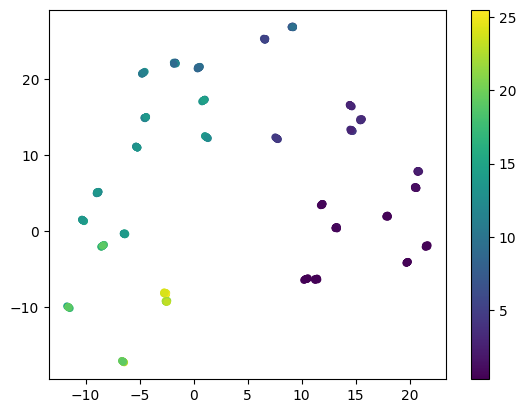

In [62]:
plt.scatter(*embedding.T, c=data.STN_beta_power, s=20)
plt.colorbar()

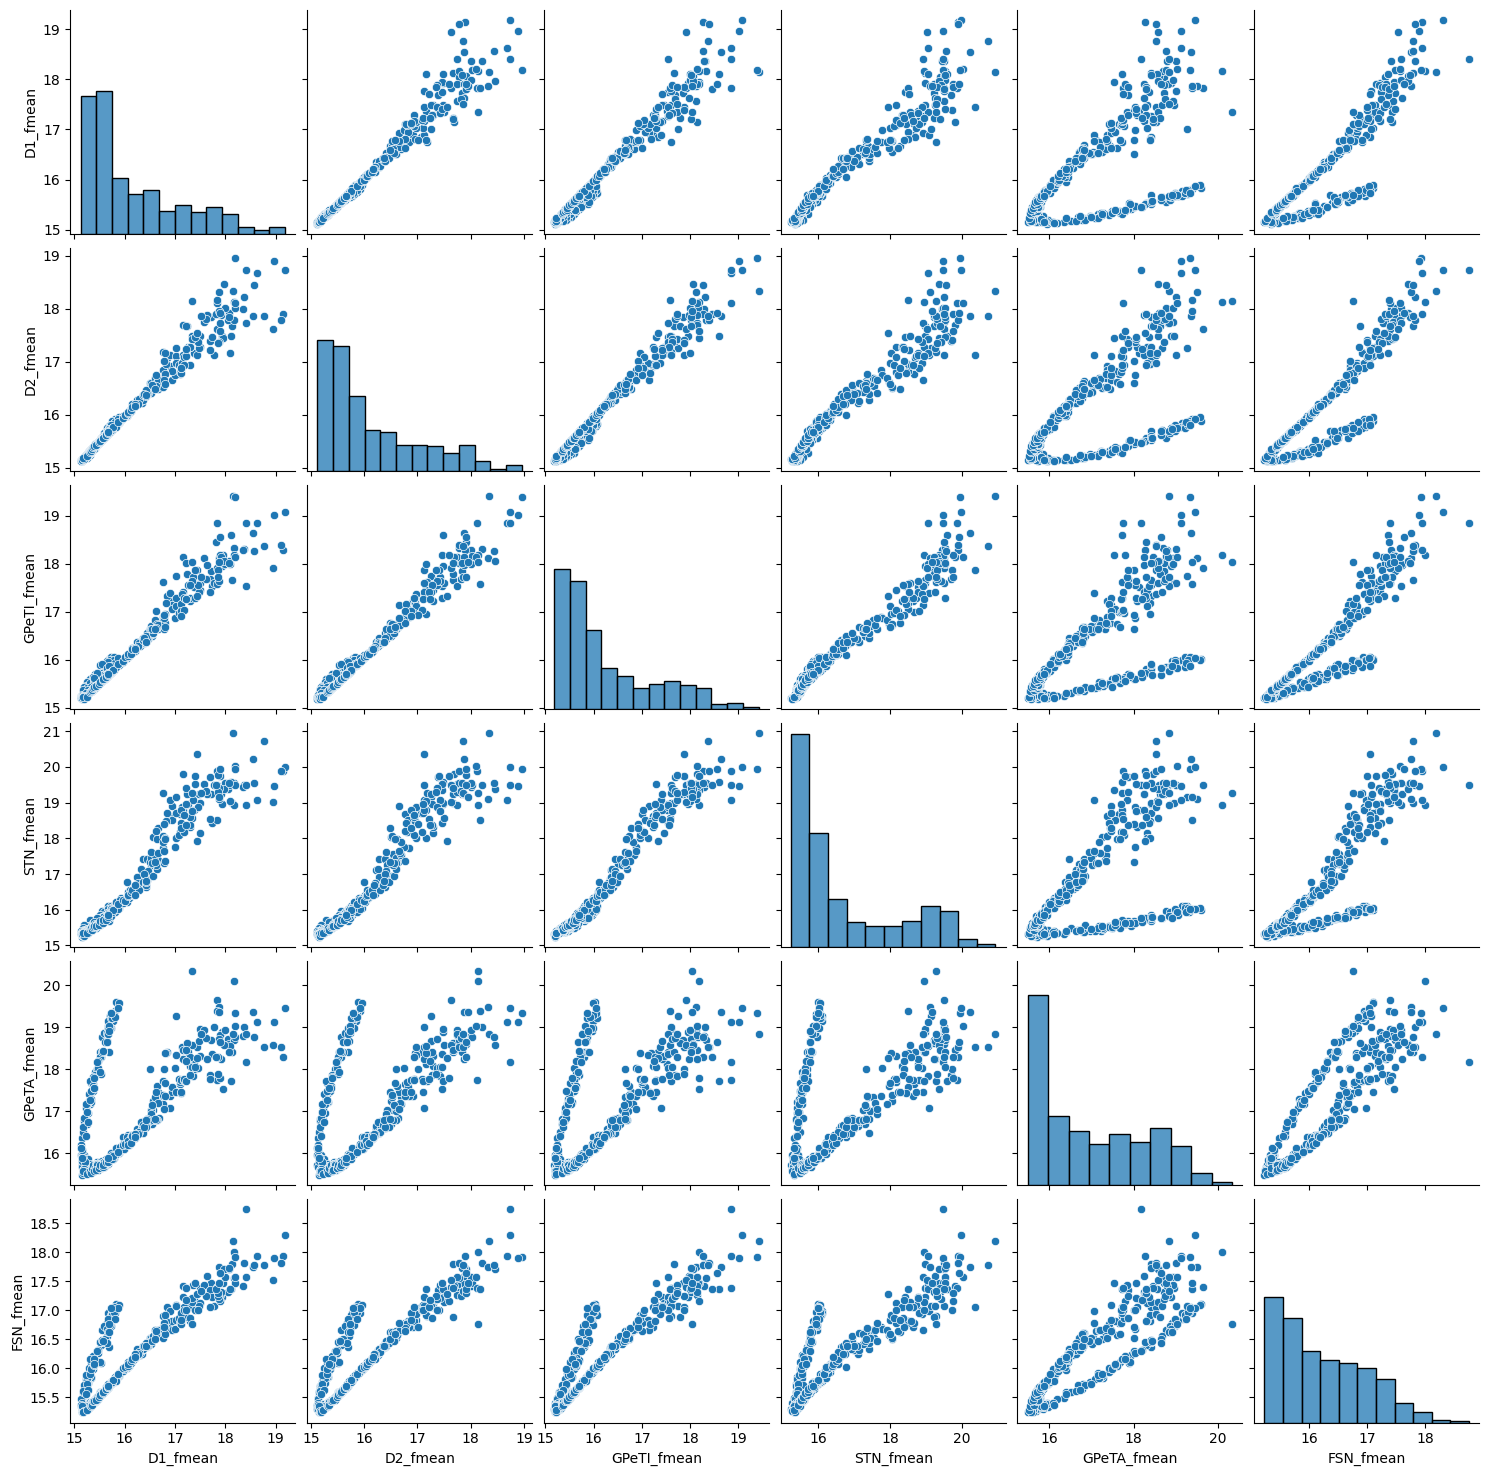

In [63]:
fmean_data = data[[o for o in observables if "fmean" in o]]
order = [f"{pop}_fmean" for pop in ["D1", "D2", "GPeTI", "STN", "GPeTA", "FSN"]]
fmean_data=fmean_data.reindex(columns=order)
sns.pairplot(fmean_data)

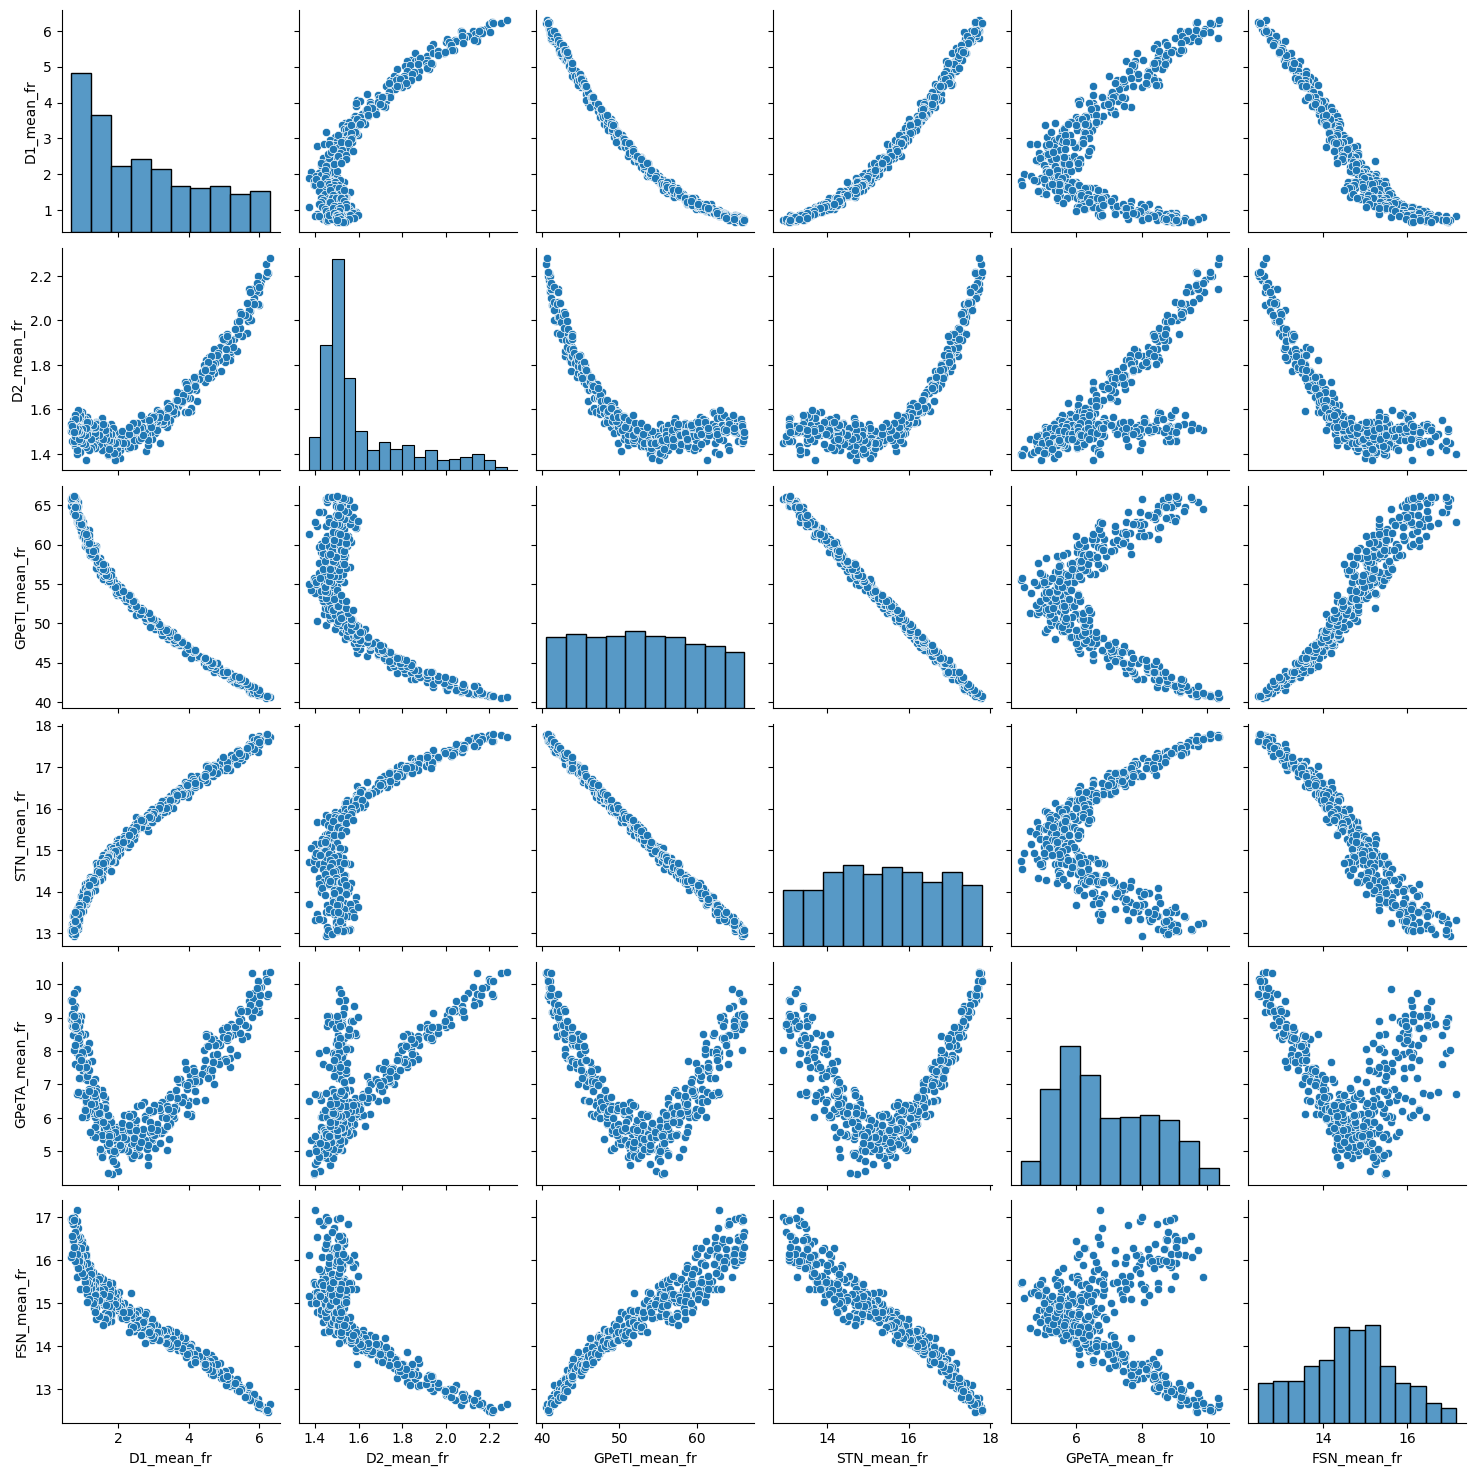

In [64]:
mean_fr_data = data[[o for o in observables if "mean_fr" in o]]
order = [f"{pop}_mean_fr" for pop in ["D1", "D2", "GPeTI", "STN", "GPeTA", "FSN"]]
mean_fr_data=mean_fr_data.reindex(columns=order)
sns.pairplot(mean_fr_data)

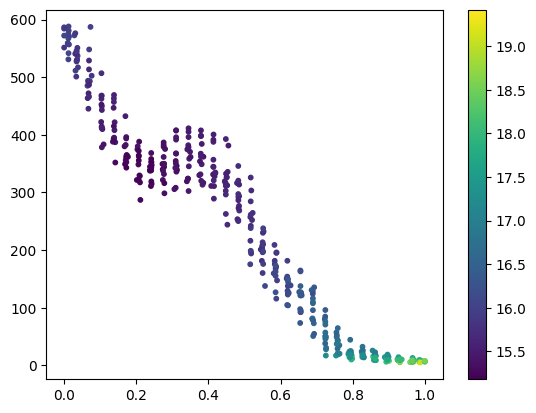

In [65]:
plt.scatter(data.alpha, data.GPeTI_beta_power, c=data.GPeTI_fmean, s=10)
plt.colorbar()

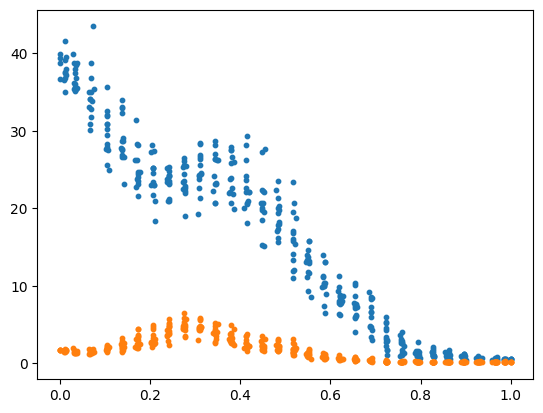

In [85]:
pop = "FSN"
plt.scatter(data.alpha, data[f"{pop}_beta_power"],s=10)
plt.scatter(data.alpha, data[f"{pop}_low_gamma_power"], s=10)
# plt.scatter(data.alpha, data[f"{pop}_high_gamma_power"], s=10)

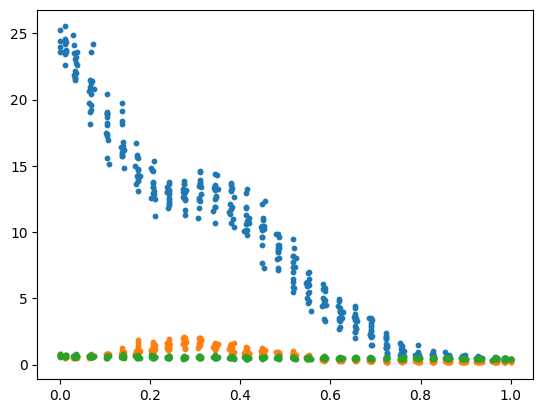

In [67]:
pop = "STN"
plt.scatter(data.alpha, data[f"{pop}_beta_power"],s=10)
plt.scatter(data.alpha, data[f"{pop}_low_gamma_power"], s=10)
plt.scatter(data.alpha, data[f"{pop}_high_gamma_power"], s=10)

/tmp/ipykernel_1029516/402417751.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison.loc[:, "difference"] =  comparison.loc[:, f"{pop1}_fmean"].to_numpy() - comparison[f"{pop2}_fmean"].to_numpy()
/tmp/ipykernel_1029516/402417751.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison["alpha"] = np.mean(comparison[features], axis=1)
/tmp/ipykernel_1029516/402417751.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

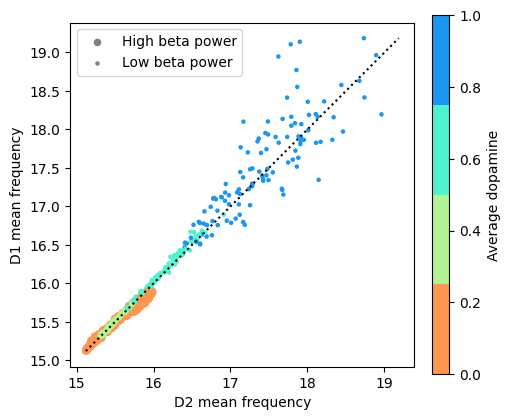

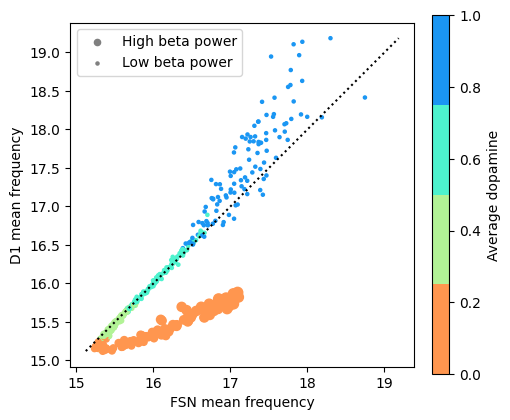

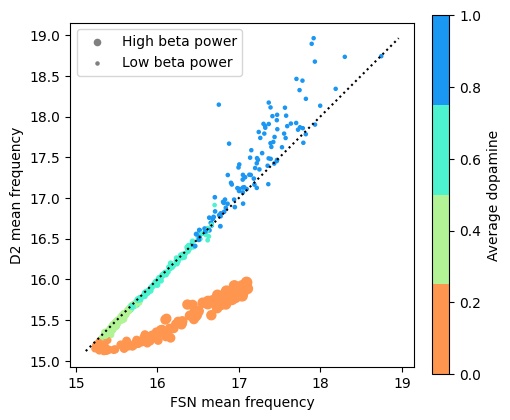

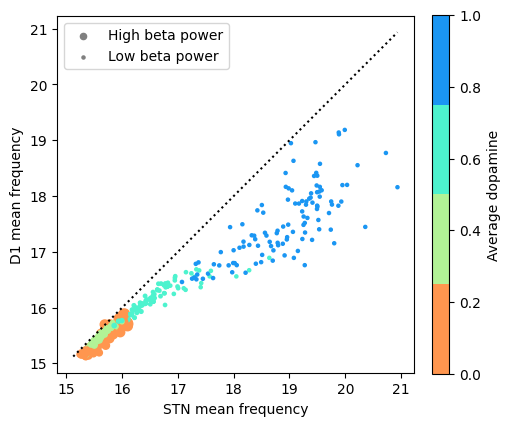

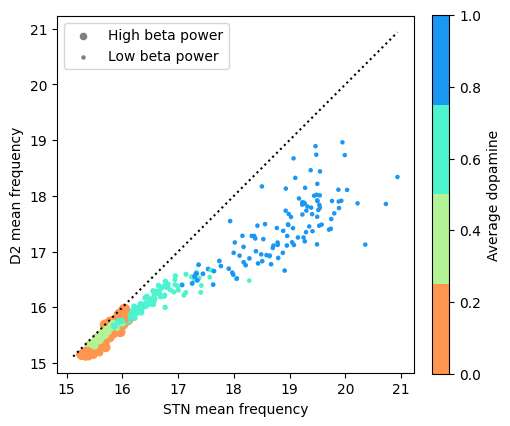

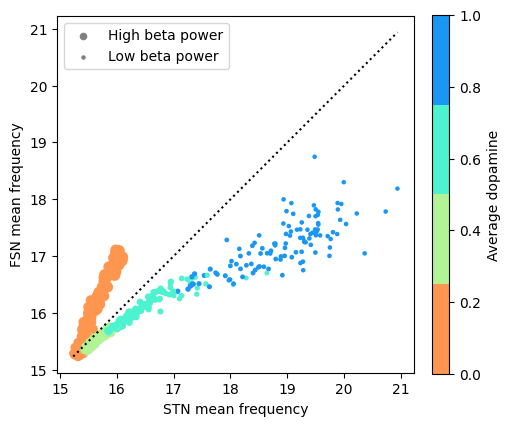

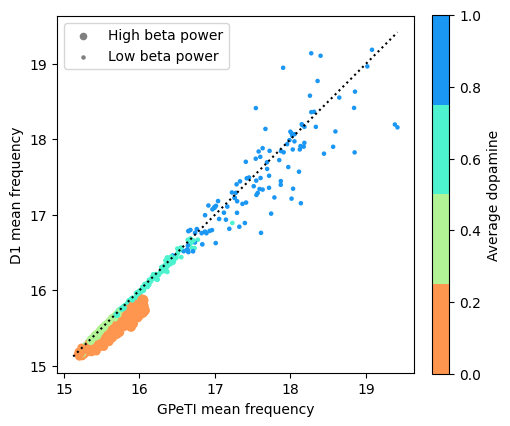

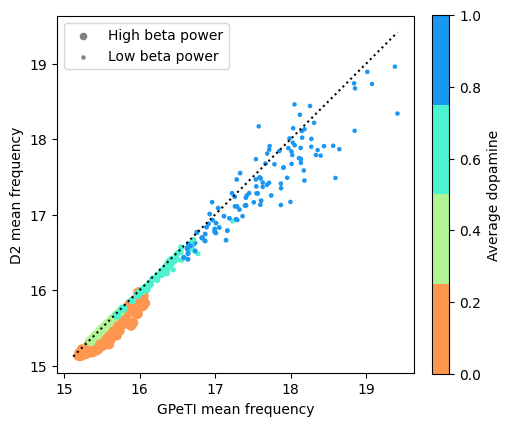

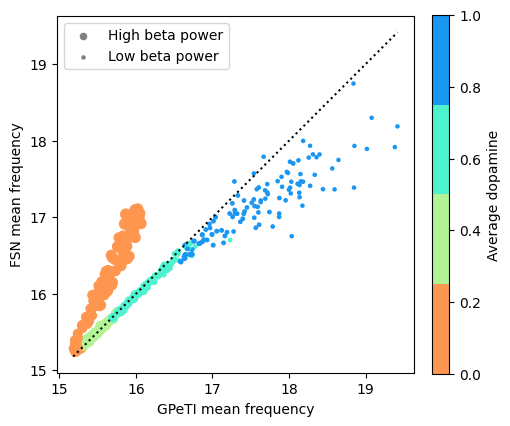

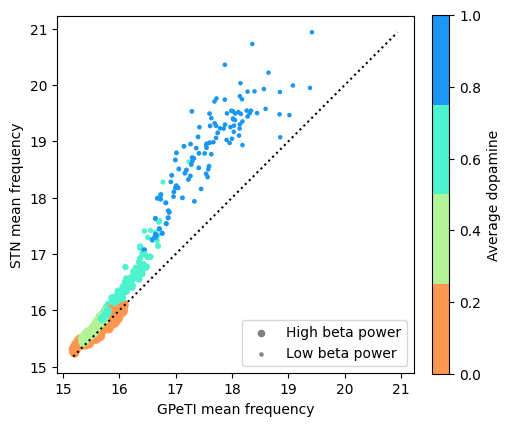

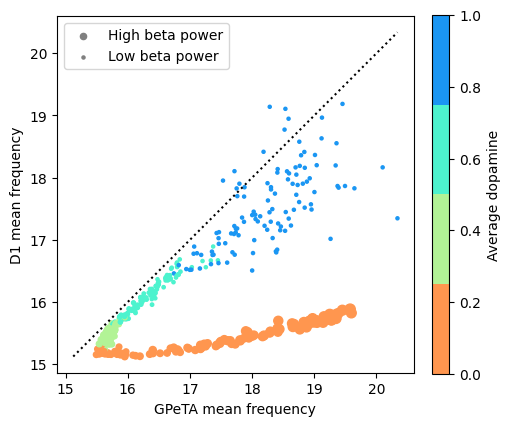

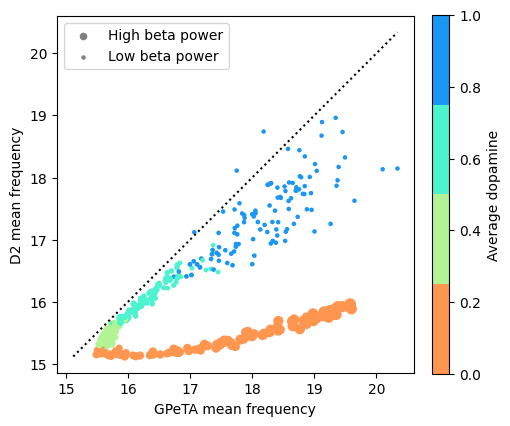

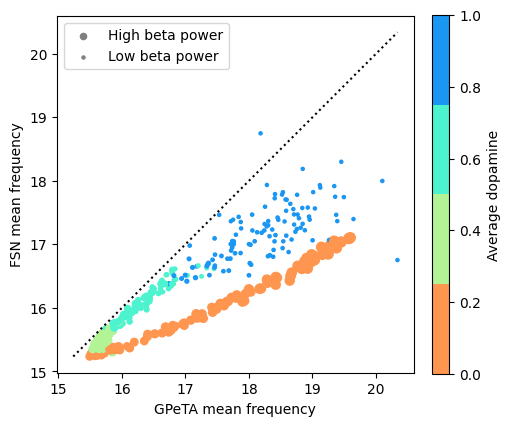

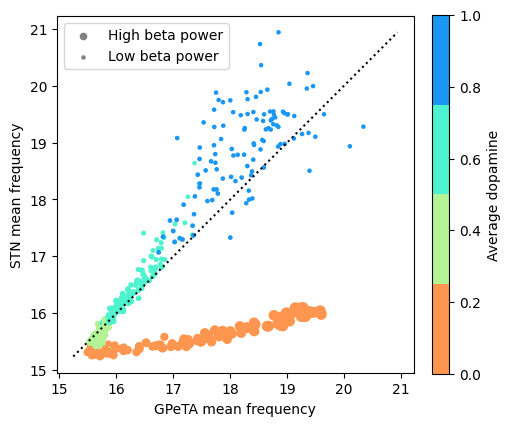

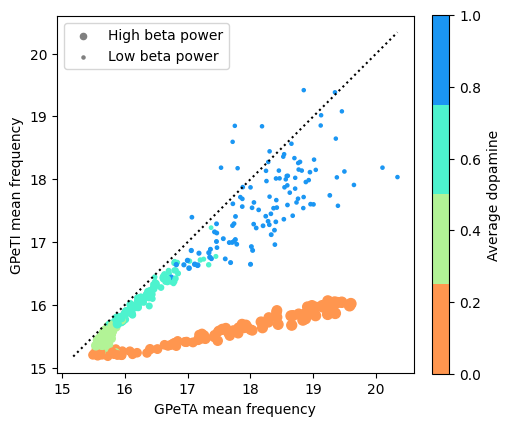

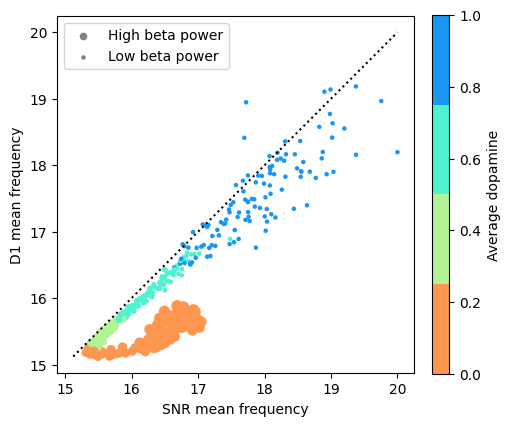

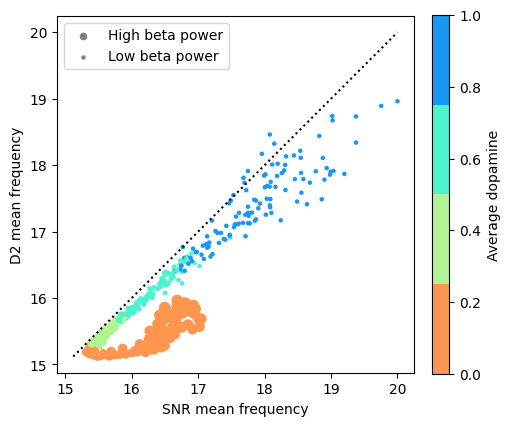

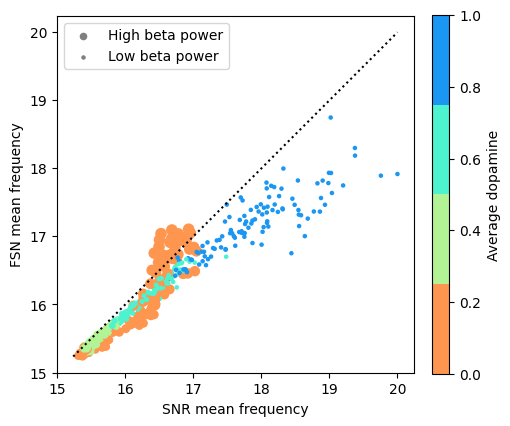

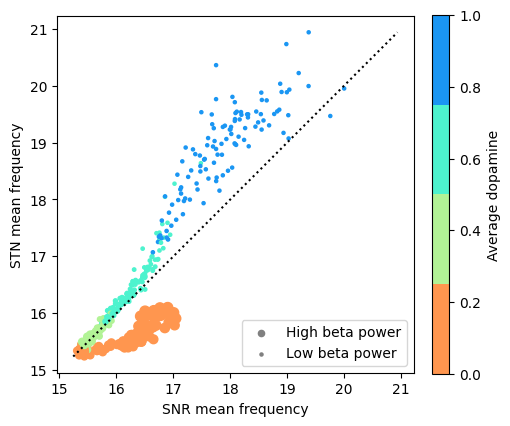

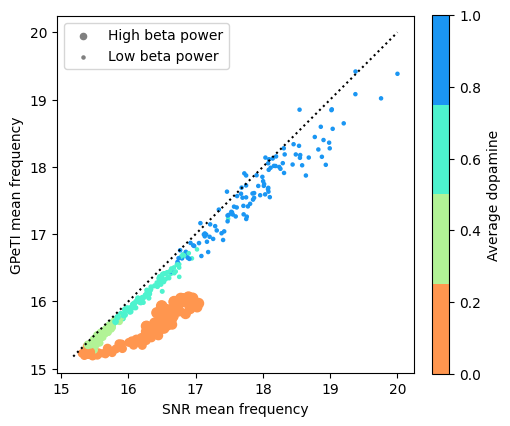

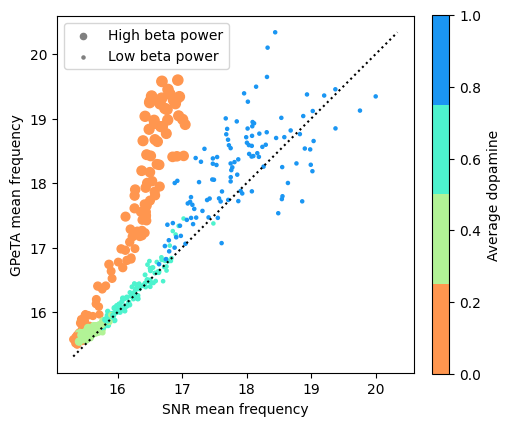

In [88]:
from matplotlib.colors import ListedColormap

pop1 = "STN"
pop2 = "GPeTI"

cmap = ListedColormap(sns.color_palette("rainbow_r", 4).as_hex())
for i in range(len(populations)):
    for j in range(i):
        pop1 = populations[i]
        pop2 = populations[j]
        comparison = data[features + [f"{pop1}_fmean", f"{pop2}_fmean"]]
        comparison.loc[:, "difference"] =  comparison.loc[:, f"{pop1}_fmean"].to_numpy() - comparison[f"{pop2}_fmean"].to_numpy()
        comparison["alpha"] = np.mean(comparison[features], axis=1)
        # plt.scatter(comparison.alpha, np.abs(comparison.difference))
        
        size = data[f"{pop1}_beta_power"] + data[f"{pop2}_beta_power"]
        size = 50*MinMaxScaler().fit_transform(size.to_numpy().reshape(-1,1)) + 5
        
        fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
        
        plt.scatter(comparison[f"{pop1}_fmean"], comparison[f"{pop2}_fmean"], 
                    c= comparison.alpha, 
                    s=size, 
                    cmap=cmap
        )
        cbar = plt.colorbar(shrink=0.73)
        cbar.set_label("Average dopamine")
        plt.xlabel(f"{pop1} mean frequency")
        plt.ylabel(f"{pop2} mean frequency")
        
        allvals = np.concatenate((comparison[f"{pop1}_fmean"],comparison[f"{pop2}_fmean"]))
        
        plt.plot([np.min(allvals), np.max(allvals)], 
                 [np.min(allvals), np.max(allvals)],
                color="k", ls=":")
        ax.set_aspect("equal")
        
        # Creiamo una legenda personalizzata
        plt.scatter([], [], color='gray', s=20, label='High beta power')  # Pallino grigio grande
        plt.scatter([], [], color='gray', s=5, label='Low beta power')    # Pallino grigio piccolo

        # plt.scatter(data[f"{pop1}_fmax"], data[f"{pop2}_fmax"], s=2, color="k")
        # Aggiungiamo la legenda al plot
        plt.legend()
        plt.savefig(f"images/loops_syncronization_{pop1}{pop2}.pdf", bbox_inches="tight")

/tmp/ipykernel_1029516/2525767357.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison.loc[:, "difference"] =  comparison.loc[:, f"{pop1}_mean_fr"].to_numpy() - comparison[f"{pop2}_mean_fr"].to_numpy()
/tmp/ipykernel_1029516/2525767357.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison["alpha"] = np.mean(comparison[features], axis=1)
/tmp/ipykernel_1029516/2525767357.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

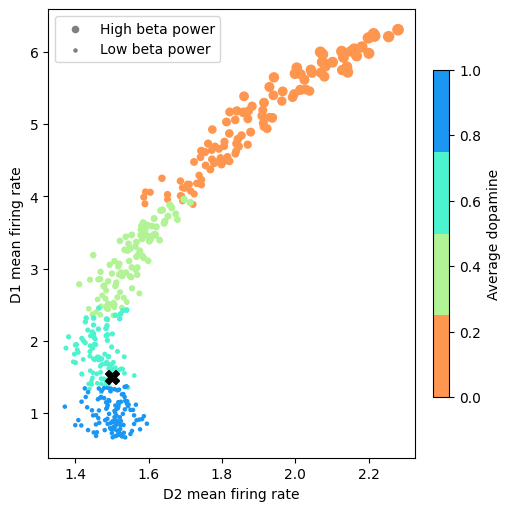

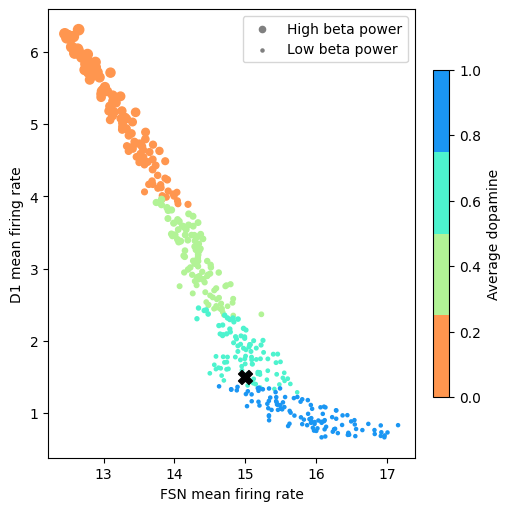

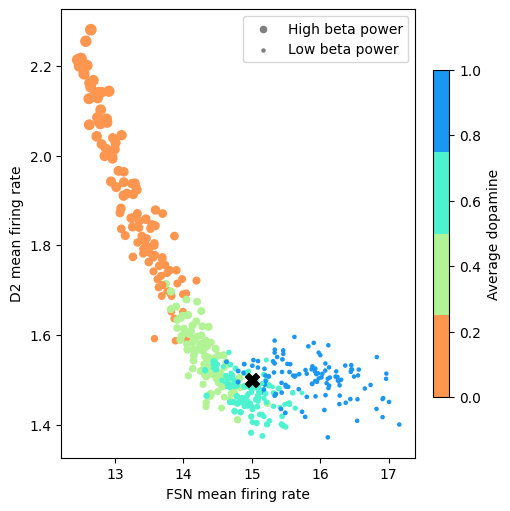

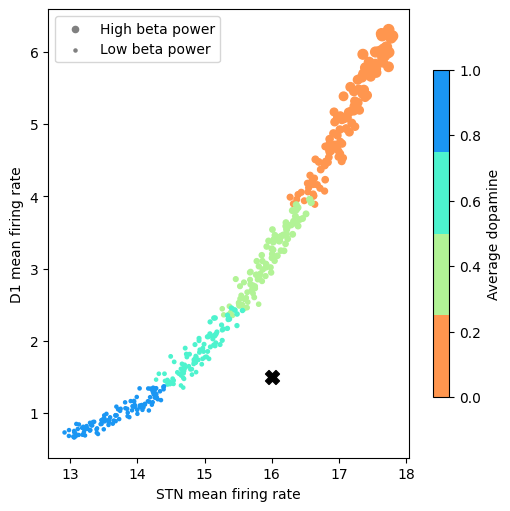

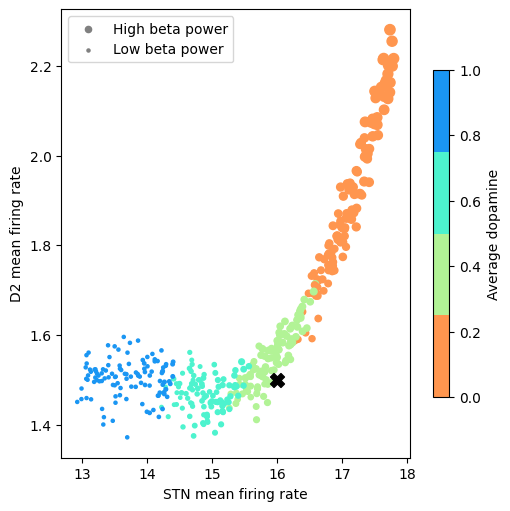

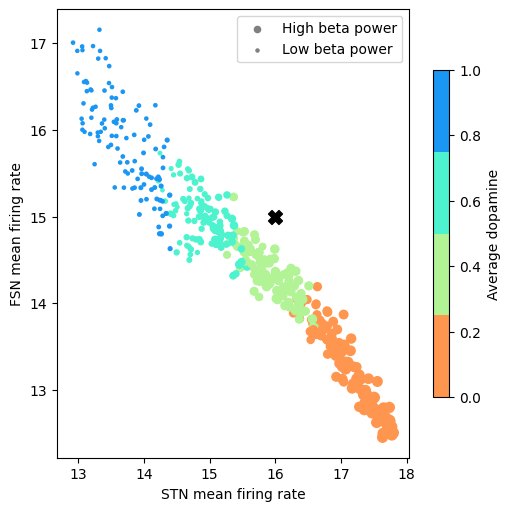

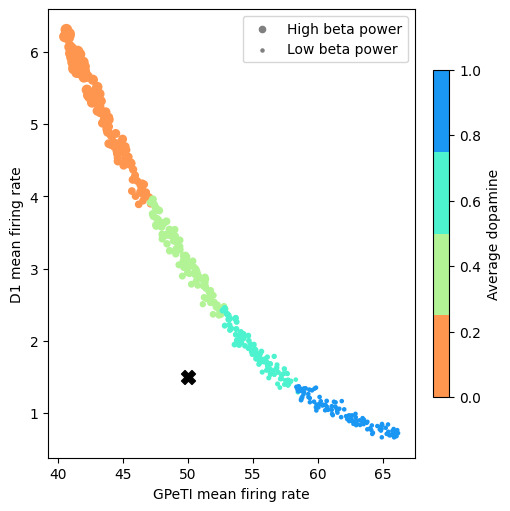

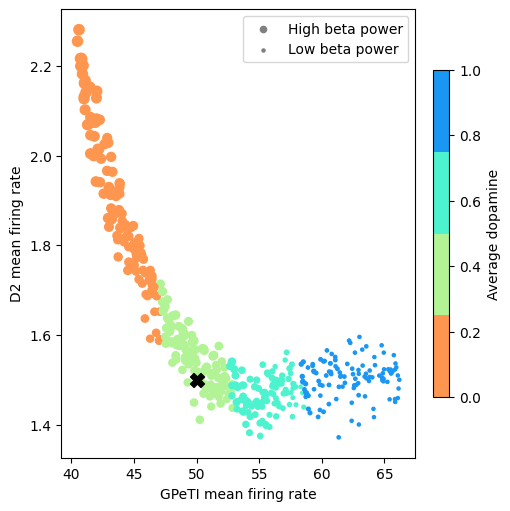

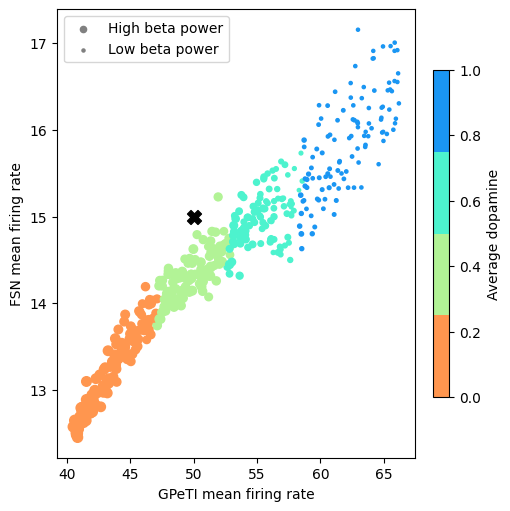

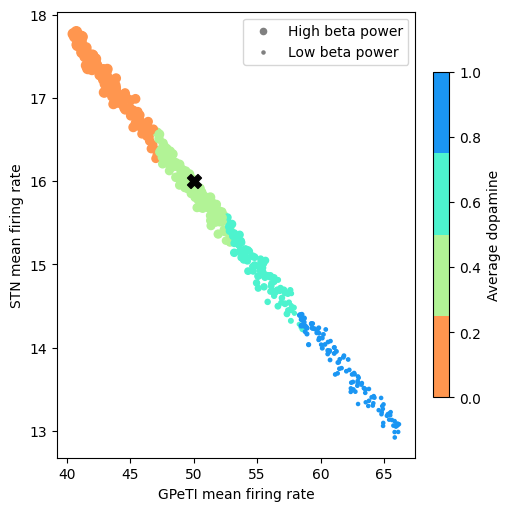

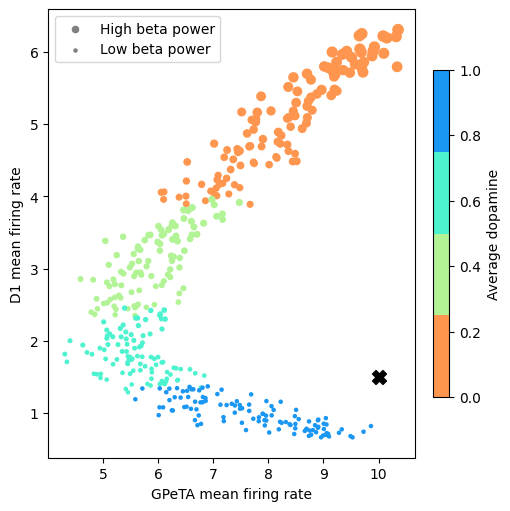

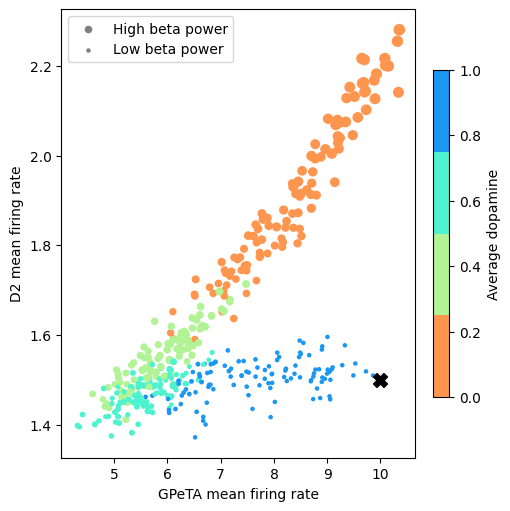

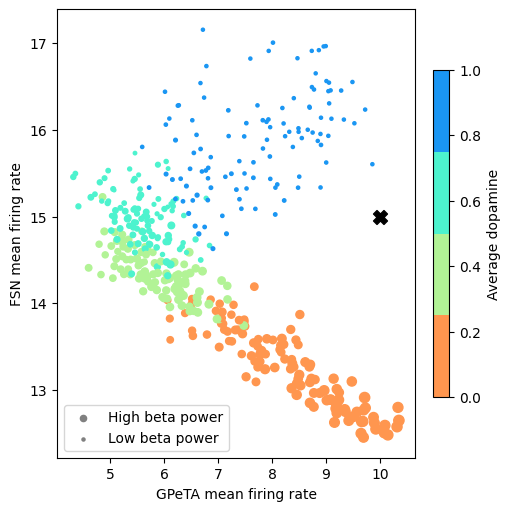

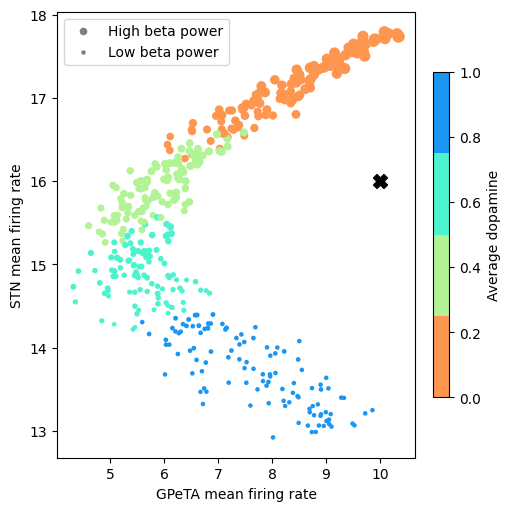

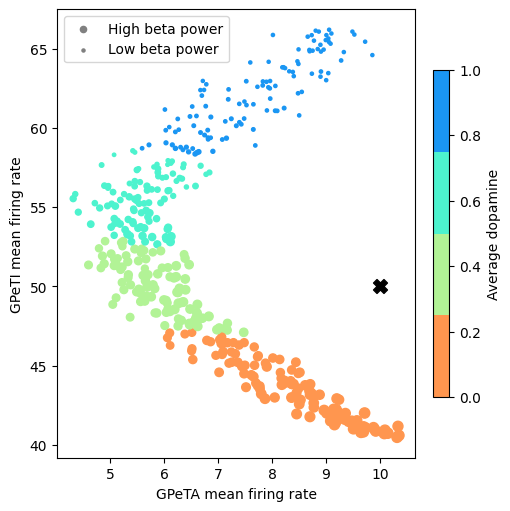

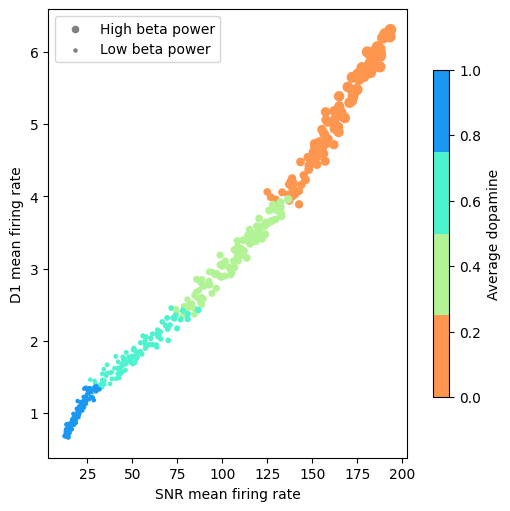

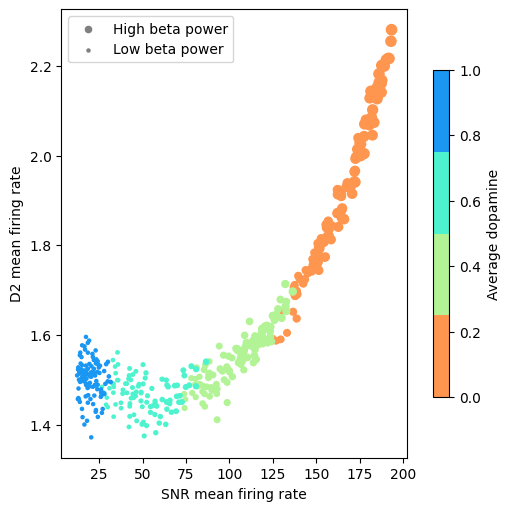

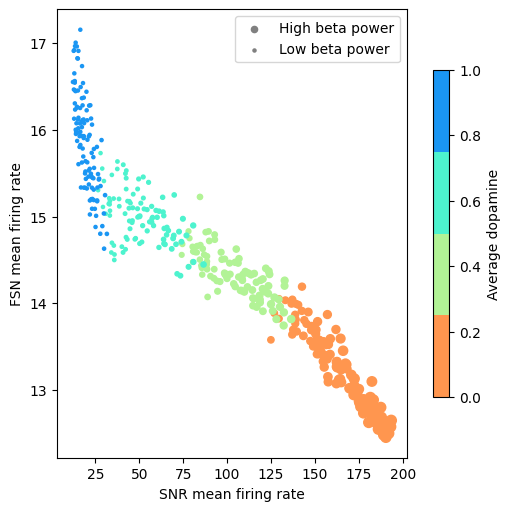

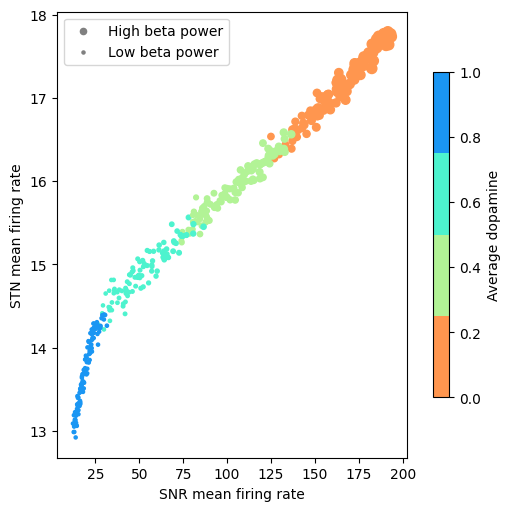

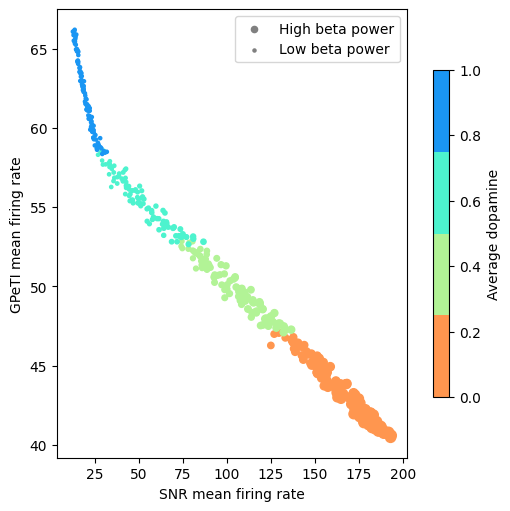

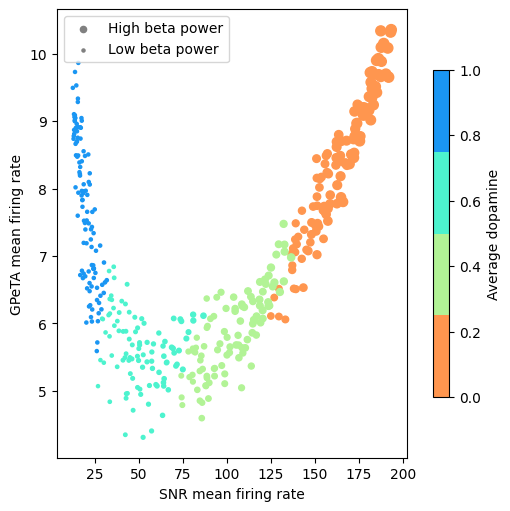

In [89]:
from matplotlib.colors import ListedColormap

pop1 = "STN"
pop2 = "GPeTI"

cmap = ListedColormap(sns.color_palette("rainbow_r", 4).as_hex())
for i in range(len(populations)):
    for j in range(i):
        pop1 = populations[i]
        pop2 = populations[j]
        comparison = data[features + [f"{pop1}_mean_fr", f"{pop2}_mean_fr"]]
        comparison.loc[:, "difference"] =  comparison.loc[:, f"{pop1}_mean_fr"].to_numpy() - comparison[f"{pop2}_mean_fr"].to_numpy()
        comparison["alpha"] = np.mean(comparison[features], axis=1)
        # plt.scatter(comparison.alpha, np.abs(comparison.difference))
        
        size = data[f"{pop1}_beta_power"] + data[f"{pop2}_beta_power"]
        size = 50*MinMaxScaler().fit_transform(size.to_numpy().reshape(-1,1)) + 5
        
        fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
        
        plt.scatter(comparison[f"{pop1}_mean_fr"], comparison[f"{pop2}_mean_fr"], 
                    c= comparison.alpha, 
                    s=size, 
                    cmap=cmap
        )
        cbar = plt.colorbar(shrink=0.73)

        try:
            plt.scatter([reasonable_firing[pop1]], [reasonable_firing[pop2]], s=100, marker="X", color="k")
        except KeyError:
            pass
        cbar.set_label("Average dopamine")
        plt.xlabel(f"{pop1} mean firing rate")
        plt.ylabel(f"{pop2} mean firing rate")
        
        # allvals = np.concatenate((comparison[f"{pop1}_mean_fr"],comparison[f"{pop2}_mean_fr"]))
        
        # plt.plot([np.min(allvals), np.max(allvals)], 
        #          [np.min(allvals), np.max(allvals)],
        #         color="k", ls=":")
        # ax.set_aspect("equal")
        
        # Creiamo una legenda personalizzata
        plt.scatter([], [], color='gray', s=20, label='High beta power')  # Pallino grigio grande
        plt.scatter([], [], color='gray', s=5, label='Low beta power')    # Pallino grigio piccolo

        # plt.scatter(data[f"{pop1}_fmax"], data[f"{pop2}_fmax"], s=2, color="k")
        # Aggiungiamo la legenda al plot
        plt.legend()
        plt.savefig(f"images/firing_rates_{pop1}{pop2}.pdf", bbox_inches="tight")

/tmp/ipykernel_1029516/4019579108.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fmean_difference = pd.concat([fmean_difference, row])


<Axes: >

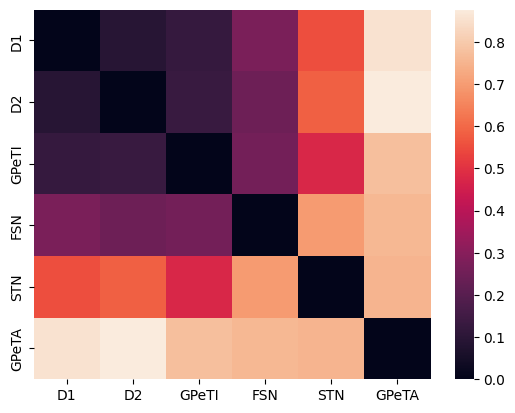

In [90]:
fmean_data = data[[o for o in observables if "fmean" in o]]
order = [f"{pop}_fmean" for pop in ["D1", "D2", "GPeTI", "STN", "GPeTA", "FSN"]]
fmean_data=fmean_data.reindex(columns=order)

fmean_difference = pd.DataFrame(columns=["D1", "D2", "GPeTI", "FSN", "STN", "GPeTA"])
for pop1 in fmean_difference.columns:
    row = dict()
    for pop2 in fmean_difference.columns:
        row[pop2] = np.mean(np.abs(fmean_data[f"{pop1}_fmean"] - fmean_data[f"{pop2}_fmean"]))
    row = pd.DataFrame(row, index=[pop1])
    fmean_difference = pd.concat([fmean_difference, row])
fmean_difference

# fmean_difference.index=["D1", "D2", "GPeTI", "STN", "GPeTA", "FSN"]
# fmean_data
# plt.gca().set_aspect("equal")
sns.heatmap(fmean_difference)

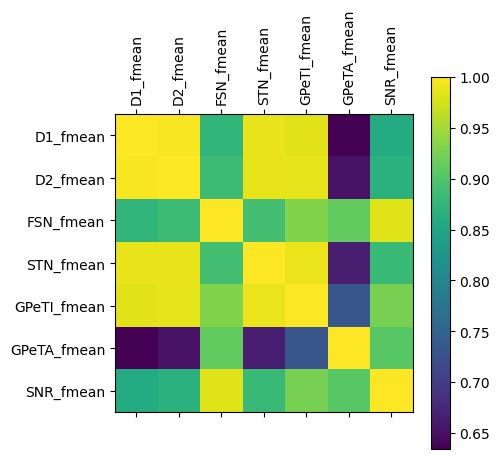

In [91]:
from scipy.stats import  spearmanr

populations = ["D1", "D2", "FSN", "STN", "GPeTI", "GPeTA", "SNR"]
beta_power_observables = [f"{pop}_fmean" for pop in populations]

M = len(beta_power_observables)
spearman_beta = np.zeros((M, M))

for i in range(M):
    for j in range(M):
        spearman_beta[i,j] = spearmanr(data[beta_power_observables[i]], data[beta_power_observables[j]])[0]

plt.matshow(spearman_beta)
plt.yticks(range(M), labels=beta_power_observables);
plt.xticks(range(M), labels=beta_power_observables, rotation=90);
plt.colorbar()
# sns.heatmap|(spearman_beta, annot=True)


### Neural networks

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [137]:
from sklearn.model_selection import train_test_split


train_ids, val_ids = train_test_split(np.arange(len(X)),  test_size=0.1)

pop = "GPeTI"
analysis_feature1 = "norm_beta_power"
analysis_feature2 = "norm_low_gamma_power"
analysis_feature3 = "norm_high_gamma_power"

y = data[f"{pop}_{analysis_feature2}"].to_numpy()

In [124]:
from sklearn.metrics import mean_squared_error
import optuna

def create_model(params):

    model = Sequential()
    model.add(Dense(X.shape[1], activation='linear'))

    for i in range(params["n_hidden"]):
        model.add(Dense(params["n_units"], activation='softplus'))

    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error',
                  optimizer="adam")
    return model


# objective function to be minimized
def objective_fun(trial):
    
    params = dict(n_units=trial.suggest_int("n_units", 64, 256),
                 n_hidden=trial.suggest_int("n_hidden", 8, 16),
#                  learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-1)
                 )
    
    model = create_model(params)
    model.fit(X[train_ids], y[train_ids], 
              epochs=trial.suggest_int("epochs", 150, 200), 
              batch_size=10, 
              validation_data=(X[val_ids], y[val_ids]), 
              verbose=False)
    y_pred = model.predict(X[val_ids], verbose=False)

    error = mean_squared_error(y_pred, y[val_ids])
    return error


study = optuna.create_study(direction="minimize")
study.optimize(objective_fun, n_trials=100, n_jobs=-1)

[I 2024-03-26 13:14:43,723] A new study created in memory with name: no-name-f345c044-f04a-458f-91ce-67fa2c89e57c
[I 2024-03-26 13:16:04,345] Trial 7 finished with value: 0.00010433778119890887 and parameters: {'n_units': 77, 'n_hidden': 12, 'epochs': 159}. Best is trial 7 with value: 0.00010433778119890887.
[I 2024-03-26 13:16:06,861] Trial 6 finished with value: 7.839617597459991e-05 and parameters: {'n_units': 147, 'n_hidden': 10, 'epochs': 186}. Best is trial 6 with value: 7.839617597459991e-05.
[I 2024-03-26 13:16:07,469] Trial 0 finished with value: 0.00019373648802545164 and parameters: {'n_units': 86, 'n_hidden': 10, 'epochs': 182}. Best is trial 6 with value: 7.839617597459991e-05.
[I 2024-03-26 13:16:08,937] Trial 4 finished with value: 7.634530397929736e-05 and parameters: {'n_units': 112, 'n_hidden': 14, 'epochs': 161}. Best is trial 4 with value: 7.634530397929736e-05.
[I 2024-03-26 13:16:10,663] Trial 2 finished with value: 0.00014297172888084233 and parameters: {'n_units

In [139]:
params = dict(n_hidden=10, n_units=128)

pop = "GPeTI"
params = study.best_params
nn1 = create_model(params)
nn1.fit(X, data[f"{pop}_{analysis_feature1}"], epochs=300, batch_size=100, verbose=False)

nn2 = create_model(params)
nn2.fit(X, data[f"{pop}_{analysis_feature2}"], epochs=300, batch_size=100, verbose=False)

nn3 = create_model(params)
nn3.fit(X, data[f"{pop}_{analysis_feature3}"], epochs=300, batch_size=100, verbose=False)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


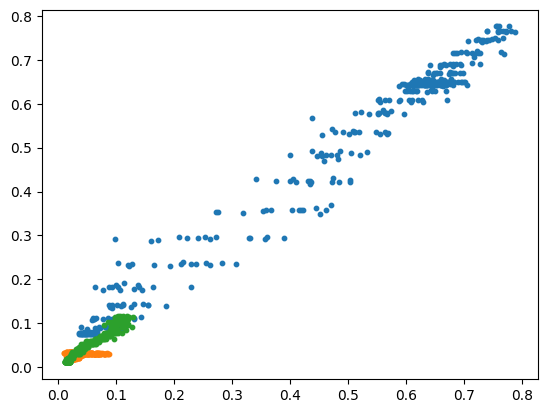

In [140]:
plt.scatter(data[f"{pop}_{analysis_feature1}"], nn1.predict(X), s=10)
plt.scatter(data[f"{pop}_{analysis_feature2}"], nn2.predict(X), s=10)
plt.scatter(data[f"{pop}_{analysis_feature3}"], nn3.predict(X), s=10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Text(0, 0.5, 'GPeTI')

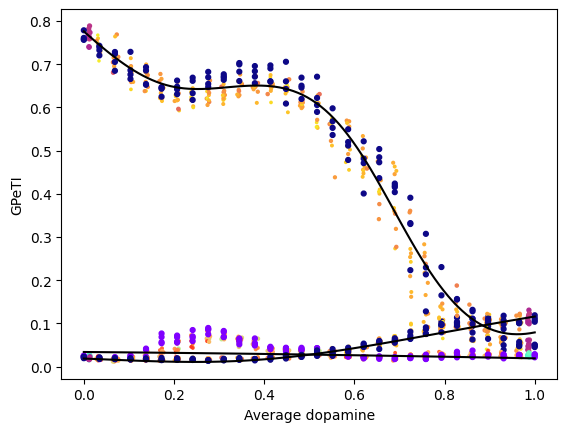

In [144]:
XX = np.repeat(np.linspace(0.0, 1.0, 100), X.shape[1]).reshape(-1,X.shape[1] )

plt.plot(XX[:,0], nn1.predict(XX), color="k")
plt.plot(XX[:,0], nn2.predict(XX), color="k")
plt.plot(XX[:,0], nn3.predict(XX), color="k")


importance = np.exp(-np.std(X, axis=1))
from sklearn.preprocessing import MinMaxScaler
importance = MinMaxScaler().fit_transform(importance.reshape(-1,1))

plt.scatter(np.mean(X, axis=1), data[f"{pop}_{analysis_feature1}"], s=10*(importance+0.2), alpha=1, c=importance, cmap="plasma_r")
plt.scatter(np.mean(X, axis=1), data[f"{pop}_{analysis_feature2}"], s=10*(importance+0.2), alpha=1, c=importance, cmap="rainbow_r")
plt.scatter(np.mean(X, axis=1), data[f"{pop}_{analysis_feature3}"], s=10*(importance+0.2), alpha=1, c=importance, cmap="plasma_r")

plt.xlabel("Average dopamine")
plt.ylabel(pop)

#### Local relevance

In [1280]:
from sklearn.linear_model import LinearRegression

In [1281]:
N = 300
l = 0.002

relevance_df = pd.DataFrame()
for alpha0 in np.linspace(0, 1, 50):
    XX = np.random.normal(alpha0, l, size=(N, X.shape[1]))

    yy = nn.predict(XX)

    local_model = LinearRegression()
    local_model.fit(XX, yy);
    local_model.coef_

    row = dict(alpha=[alpha0]*len(features), 
               feature=features, 
               relevance=local_model.coef_[0],
               function_value=[np.mean(y)]*len(features)
               )
    row = pd.DataFrame(row)
    relevance_df = pd.concat([relevance_df, row])
# relevance_df = relevance_df.sort_values(by="relevance")
relevance_df

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


alpha            feature  relevance  function_value
0     0.0            FSN_E_l  -3.435109       15.601582
1     0.0          GPeTI_E_l  -3.481455       15.601582
2     0.0          GPeTA_E_l  -2.701898       15.601582
3     0.0          D1_V_peak  -5.153729       15.601582
4     0.0           D1_ada_b  -3.714669       15.601582
..    ...                ...        ...             ...
23    1.0      D2->D1_weight  -0.093255       15.601582
24    1.0      D2->D2_weight  -0.122588       15.601582
25    1.0   GPeTA->D1_weight  -0.044283       15.601582
26    1.0     D1->SNR_weight  -0.072026       15.601582
27    1.0  GPeTI->STN_weight  -0.089896       15.601582

[1400 rows x 4 columns]

In [1282]:
# Remove the less relevant
total_relevances = []
for feat in features:
    dd = relevance_df.loc[ relevance_df.feature == feat ]
    tot_rel = np.sum( dd.relevance.to_numpy()**2)
    total_relevances += [tot_rel]

best_rel_df = pd.DataFrame(dict(feature = features, tot_relevance = total_relevances)).sort_values(by="tot_relevance")
best_rel_df

feature  tot_relevance
21         D1->D1_weight       6.799446
15     STN->GPeTI_weight      20.680799
7      GPeTA->FSN_weight      28.649584
25      GPeTA->D1_weight      38.290320
17   D1->D1_connectivity      40.543179
13      D2->GPeTI_weight      51.901938
5                SNR_E_l      61.303042
11   GPeTI->GPeTI_weight      67.989496
18   D1->D2_connectivity      69.528720
16  FSN->D2_connectivity      77.235004
19   D2->D1_connectivity      85.903834
26        D1->SNR_weight     112.822090
2              GPeTA_E_l     119.293167
23         D2->D1_weight     193.982608
6        FSN->FSN_weight     195.552752
1              GPeTI_E_l     212.025845
4               D1_ada_b     223.379772
0                FSN_E_l     224.333744
27     GPeTI->STN_weight     228.420025
8      GPeTI->FSN_weight     230.141740
14     STN->GPeTA_weight     234.391826
20   D2->D2_connectivity     343.287499
3              D1_V_peak     441.590753
10   GPeTA->GPeTI_weight     447.983098
12   GPeTI->GPeTA_weight     450.037626
24         D2->D2_weight     458.611070
22         D1->D2_weight     474.456961
9    GPeTA->GPeTA_weight     999.843481

In [1283]:
# select best
best_feats = best_rel_df.sort_values('tot_relevance',ascending = False).head(6)
best_feats = best_feats.feature.values
best_feats

array(['GPeTA->GPeTA_weight', 'D1->D2_weight', 'D2->D2_weight',
       'GPeTI->GPeTA_weight', 'GPeTA->GPeTI_weight', 'D1_V_peak'],
      dtype=object)

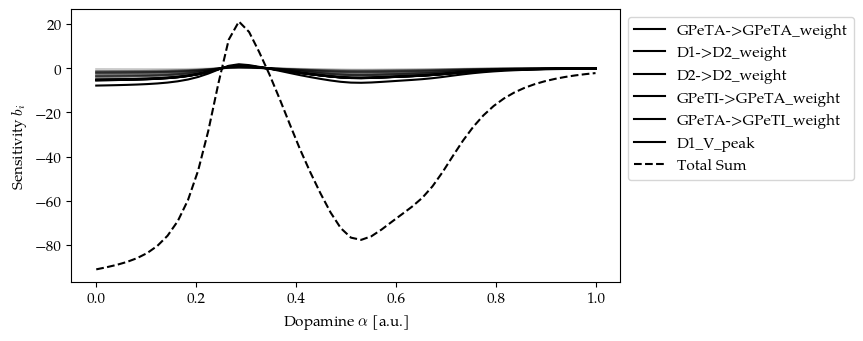

In [1284]:
plt.style.use("../style.mplstyle")
subset = relevance_df.loc[relevance_df['feature'].isin(best_feats)]
color_dict = {"GPeTA_E_l":"yellow",
              "FSN->D2_connectivity": "purple",
              "FSN->D2_connectivity": "red",
              "D2->GPeTI_weight": "blue",
              "GPeTI->GPeTI_weight": "orange",
              "GPeTI->FSN_weight": "green",
              "D2->D2_connectivity": "cyan"
              }

for bf in best_feats:
    subset = relevance_df[relevance_df.feature == bf]
    plt.plot(subset.alpha, subset.relevance, c=color_dict.get(bf, "k"), label=bf)

summ = np.zeros(len(relevance_df[relevance_df.feature == features[0]]))
summ_bests = np.zeros(len(relevance_df[relevance_df.feature == features[0]]))
summ_pippe = np.zeros(len(relevance_df[relevance_df.feature == features[0]]))

for feat in features:
    subset = relevance_df[relevance_df.feature == feat]
    summ += subset.relevance.to_numpy()
    if feat not in best_feats:
        plt.plot(subset.alpha, subset.relevance, color="k", alpha=0.2)
        summ_pippe += subset.relevance.to_numpy()

    if feat in best_feats:
        summ_bests += subset.relevance.to_numpy()

plt.plot(subset.alpha, summ, color="k", ls="--", label="Total Sum")
# plt.plot(subset.alpha, summ_bests, color="k", ls=":", label="Summ best")
# plt.plot(subset.alpha, summ_pippe, color="r", ls="--", label="Summ best")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel(r"Dopamine $\alpha$ [a.u.]")
plt.ylabel(r"Sensitivity $b_i$")

plt.savefig("relevance_alpha.pdf", bbox_inches='tight')

In [1285]:
mask = (subset.alpha > 0.3 ) & (subset.alpha < 0.6)
aa = subset.alpha[mask].to_numpy()
bb = summ[mask]

aa[np.argmax(bb)]

0.3061224489795918

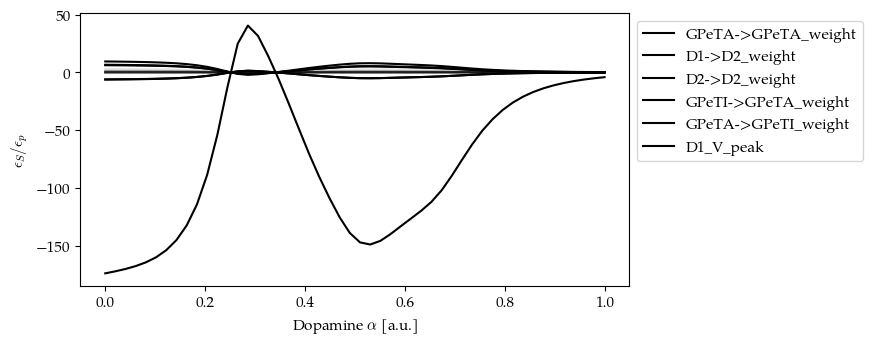

In [1286]:
plt.style.use("../style.mplstyle")
subset = relevance_df.loc[relevance_df['feature'].isin(best_feats)]
color_dict = {"GPeTA_E_l":"yellow",
              "FSN->D2_connectivity": "purple",
              "FSN->D2_connectivity": "red",
              "D2->GPeTI_weight": "blue",
              "GPeTI->GPeTI_weight": "orange",
              "GPeTI->FSN_weight": "green",
              "D2->D2_connectivity": "cyan"
              }

for bf in best_feats:
    subset = relevance_df[relevance_df.feature == bf]
    plt.plot(subset.alpha, subset.relevance/new_parameters_dict['parametric'][bf][0]['susceptibility'], 
             c=color_dict.get(bf, "k"), 
             label=bf)

for feat in features:
    if feat not in best_feats:
        subset = relevance_df[relevance_df.feature == feat]
        plt.plot(subset.alpha, subset.relevance/new_parameters_dict['parametric'][feat][0]['susceptibility']/subset.function_value, color="k", alpha=0.1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel(r"Dopamine $\alpha$ [a.u.]")
plt.ylabel(r"$\epsilon_S /\epsilon_p$")
plt.savefig("relevance_alpha_weighted.pdf", bbox_inches='tight')

### Model independent

In [1287]:
def gradient_from_irregular(points, function_evaluations):
    M = len(points)     # Number of points
    L = int(M*(M-1)/2)  # Number of couples
    dim = points.shape[1]
    
    Delta = np.zeros((L, X.shape[1]))
    B = np.zeros(L)
    # print(f"Estimating gradient on {L} couples")
    couples = 0
    couples_dict = dict()
    for i in range(M*M):
        couple_index = i + 1
        point_1 = couple_index // M
        point_2 = couple_index % M
        
        if point_1 >= point_2:
            continue
        
        for dim in range(X.shape[1]):
            Delta[couples, dim] = X[point_2, dim] - X[point_1, dim] 
        norm = np.sqrt(np.sum(Delta[couples]**2))
        
        Delta[couples] /= norm
        B[couples] = (function_evaluations[point_2] - function_evaluations[point_1])/norm
        
        couples_dict[couples] = (point_1, point_2)
        couples +=1

    # Estimate the gradient through inverse
    invmat = np.matmul( np.linalg.inv( np.matmul( Delta.T , Delta)), Delta.T)
    grad = invmat.dot(B)
    return grad

In [1288]:
from sklearn.linear_model import LinearRegression
grad_df = pd.DataFrame()
for alpha_0 in np.linspace(0, 1, 50):
    X = data[features].to_numpy()
    
    distances = np.sqrt( np.sum((X - alpha_0)**2, axis=1))
    is_local = np.argsort(distances)[:60]
    
    data_local = data.loc[is_local]
    X_local = X[is_local]
    y_local = y[is_local]

    # print(np.min(np.mean(X_local, axis=1)),np.max(np.mean(X_local, axis=1)))

    grad = gradient_from_irregular(X_local, y_local)
    # model = LinearRegression()
    # model.fit(X_local, y_local)
    # grad = model.coef_
    
    subdf = pd.DataFrame([grad], columns=features)
    subdf["alpha"] = alpha_0
    grad_df = pd.concat([grad_df, subdf])
grad_df

FSN_E_l   GPeTI_E_l   GPeTA_E_l   D1_V_peak   D1_ada_b     SNR_E_l  \
0 -16.385874  -23.851024  -23.477659   96.429626  30.221033  -19.356456   
0  -5.296910  -36.112583  -26.147129   70.934263 -15.848186  -32.676365   
0 -25.125255    9.111073  -45.666905  -19.691172 -20.419189   21.726547   
0 -32.439616    1.009165   -6.625166   58.695869 -17.061811    9.861905   
0 -21.675000   92.682828  -60.543722 -171.173309 -42.313000   -6.282922   
0  48.098331  -22.370789  -53.922078   -9.933727 -98.928020  106.973278   
0  33.782854  -38.241424 -126.724054  137.047369 -30.253714   24.813051   
0 -37.806687  131.903925  -29.706225  -99.669146 -61.131919  152.985104   
0 -60.921155   11.030509   -0.459792   -6.595911 -52.906476   99.066793   
0  47.387389    6.273431  -41.441223  -11.540460  -5.183735   10.686660   
0 -11.474949  -47.563056   37.305189   19.958663  11.735590   20.741864   
0 -11.946167  -18.003636   15.720051   78.307722  26.245962   13.715824   
0   4.994849  -21.825039   42.640187  -40.619792  51.541340  -23.759136   
0   8.459933   14.790185  -35.935034  -28.139176 -22.920031   14.157639   
0 -27.351346   -9.522935    4.698255   -1.759586  10.379176  -55.034689   
0  -6.111016    2.253269  -13.356299  -27.509032 -21.906230   10.520523   
0  16.906816  -40.846469  -33.951103   41.897167   4.191219  -16.494541   
0  49.466680   -2.752085    8.987331   20.045419 -15.291539   25.001161   
0 -71.589782  -10.287039    7.406402  -27.755126  46.625352   -5.689921   
0 -38.525243  -62.936788  -40.202745  -21.620855  31.017944  -20.504263   
0   0.650451  -14.907730  -54.443222   42.946964  -1.394923   -5.573066   
0  23.350661   21.854920   25.215856  -20.437092  12.720329  -77.518208   
0  83.976338  -15.978494    2.792587  -18.801496 -45.138071    3.115679   
0  20.920974  -49.520214   39.292426  122.879545  21.688991   24.012643   
0 -53.289404  112.714527    2.968631  -92.067185 -27.685319   22.195040   
0   7.227871 -107.789806  -11.868333   90.613288 -28.803661   57.441557   
0  78.470446  135.488605  -32.150473 -119.490821 -83.299373  -86.400490   
0 -97.388362 -121.561110  -34.277035   46.680472 -16.167890  -14.120804   
0  70.372132   -2.442254  -28.241947  126.747278 -74.373252   59.848760   
0 -70.912313   48.287049  -24.185624  -26.261757 -41.185046   -0.884311   
0  49.169968  -42.822150   16.878898   62.001398  32.025263   14.244166   
0 -34.060506   28.240808   22.759303  -34.382557   4.689805    7.800153   
0 -11.078937  -57.197602  -30.401397   23.046486 -56.655976   48.832954   
0  -9.104272  -12.681188  -33.973562   27.107643  -3.093208   18.142220   
0  21.538655  -18.003755   21.453039  -22.348344 -41.733072  -26.429707   
0 -23.941577  -43.505202    1.464218   83.079000  -1.025108   -9.885396   
0 -51.926648   36.630865  -21.004674  -20.596544   2.176848   34.073412   
0  15.614648  -41.348566  -21.139896   29.393985   1.694653   12.125112   
0 -27.554924  -30.415808   -8.465506   10.971712   2.991280   15.556660   
0   6.483937    9.422922   -6.173719   -9.439410  -8.808510   -9.140684   
0  14.361685   -0.748021   15.904381   -6.947074  13.232178   -6.045399   
0  -0.043866   -6.867048    2.122773   -4.494436  13.931319    6.261007   
0  -2.743211   -2.567608   -5.063576    0.701065  -0.134965   -1.017014   
0   3.779893    2.589382    1.734426    3.906434  -1.004473    3.641330   
0  -1.742125    5.823062   -1.477578   -0.958133   1.139230   -1.418127   
0   4.756057   -6.613888    1.856851    8.230645   1.775001   -4.121040   
0  -1.240545    6.092942   -7.357185   -4.596895  -1.461270   -0.101555   
0   0.601205   -0.032369    1.929311   -0.825133   1.248492   -0.098854   
0   2.319235    2.480654   -0.350288   -1.769336  -2.660337    1.190132   
0   0.647595    5.052766    2.208161   -1.883300  -2.645039    3.153748   

   FSN->FSN_weight  GPeTA->FSN_weight  GPeTI->FSN_weight  GPeTA->GPeTA_weight  \
0       -36.103565          28.545738           5.842358           -24.211814   
0        12.08926

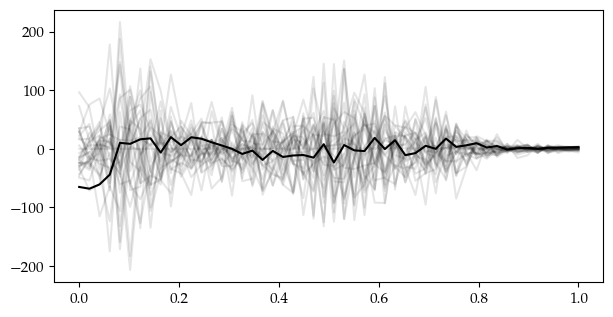

In [1289]:
for coll in grad_df.columns:
    plt.plot(grad_df.alpha, grad_df[coll], alpha=0.1, color="k")
plt.plot(grad_df.alpha, grad_df.drop(columns=["alpha"]).sum(axis=1).to_numpy(), color="k")

In [1290]:
grad = gradient_from_irregular(X, y)
param_sensitivity = np.zeros(grad.shape)
for i, feat in enumerate(features):
    param_sensitivity[i] = grad[i]/new_parameters_dict['parametric'][feat][0]['susceptibility']

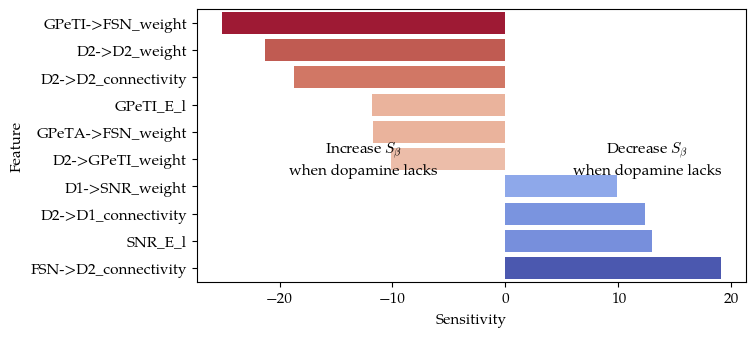

In [1291]:
grad_df = pd.DataFrame(dict(Sensitivity=grad, 
                            Feature=features,
                            ParSens=param_sensitivity,
                            abs_sensitivity=np.abs(grad)))
grad_df = grad_df.nlargest(10, "abs_sensitivity")
grad_df = grad_df.sort_values(by="Sensitivity")

xx = np.max(np.abs(grad_df.Sensitivity))/2
sns.barplot(data=grad_df, y="Feature", x="Sensitivity", hue="Sensitivity", palette="coolwarm_r", legend=False)
plt.annotate(r"Increase $S_\beta$" + "\nwhen dopamine lacks", (-xx, len(grad_df)//2), va="center", ha="center")
plt.annotate(r"Decrease $S_\beta$" + "\nwhen dopamine lacks", (xx, len(grad_df)//2), va="center", ha="center")
plt.savefig("global_relevance.pdf",bbox_inches='tight' )

Text(0.5, 0, 'Parameter Sensitivity')

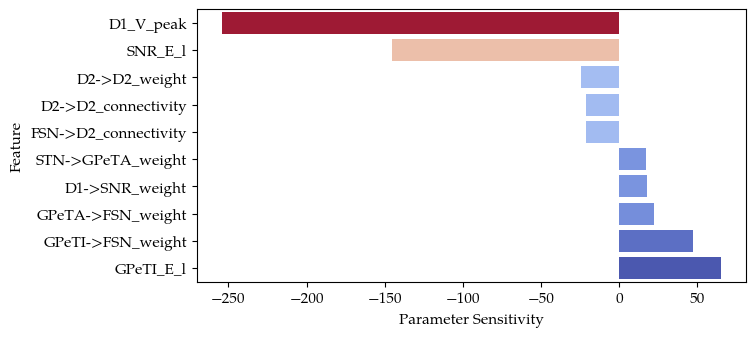

In [1292]:
grad_df = pd.DataFrame(dict(Sensitivity=grad, 
                            Feature=features,
                            ParSens=param_sensitivity,
                            abs_sensitivity=np.abs(grad),
                            abs_parsens=np.abs(param_sensitivity)))
grad_df = grad_df.nlargest(10, "abs_parsens")
grad_df = grad_df.sort_values(by="ParSens")

xx = np.max(np.abs(grad_df.ParSens))/2

bp = sns.barplot(data=grad_df, y="Feature", x="ParSens", hue="ParSens", palette="coolwarm_r", legend=False)
bp.set_xlabel("Parameter Sensitivity")

# norm = plt.Normalize(grad_df.Sensitivity.min(), grad_df.Sensitivity.max())
# sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
# cbar = ax.figure.colorbar(sm, ax=bp)
# cbar.set_label("Dopamine sensitivity")
